# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to classify an image as a certain label. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.



In [2]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from planktonclas import paths, utils, data_utils
from planktonclas.data_utils import load_data_splits, load_class_names, k_crop_data_sequence
from planktonclas.test_utils import predict
from planktonclas.visualization.saliency import GradientSaliency
from planktonclas.visualization.guided_backprop import GuidedBackprop
from planktonclas.visualization.integrated_gradients import IntegratedGradients
from planktonclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = 'Phytoplankton_EfficientNetV2B0'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 5                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects())

Loading class names...


In [3]:
import os
import json
from planktonclas import test_utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,roc_auc_score
from planktonclas.data_utils import load_image, load_class_names
from planktonclas import paths, plot_utils
from planktonclas.plot_utils import create_pred_path,plt_conf_matrix
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.
# User parameters to set
TIMESTAMP = '2025-10-21_154558'           # timestamp of the model
SPLIT_NAME = 'DS_split'                   # dataset split to predict
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction
TOP_K = 5                             # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load clas names
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)
data = pd.DataFrame(pred_dict)
data[['filenames', 'true_lab','pred_lab']].head(5)
data['in_top5'] = data.apply(lambda row: row['true_lab'] in row['pred_lab'], axis=1)
data['top1_correct'] = data.apply(lambda row: row['true_lab'] == row['pred_lab'][0], axis=1)
data['true_label']=class_names[data['true_lab']]
data['top1']=data.apply(lambda row: class_names[row['pred_lab'][0]], axis=1)
data['probability']=data.apply(lambda row: row['pred_prob'][0], axis=1)
flat_array=np.concatenate(np.array(pred_dict['pred_lab']))
data['pred_lab'] = flat_array.reshape(-1, 5)

Loading class names...


c:\Users\wout.decrop\environments\Imagine\imagine_environment\plankton_classifier\plankton_env\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 100, 100, 3))
  warnings.warn(msg)


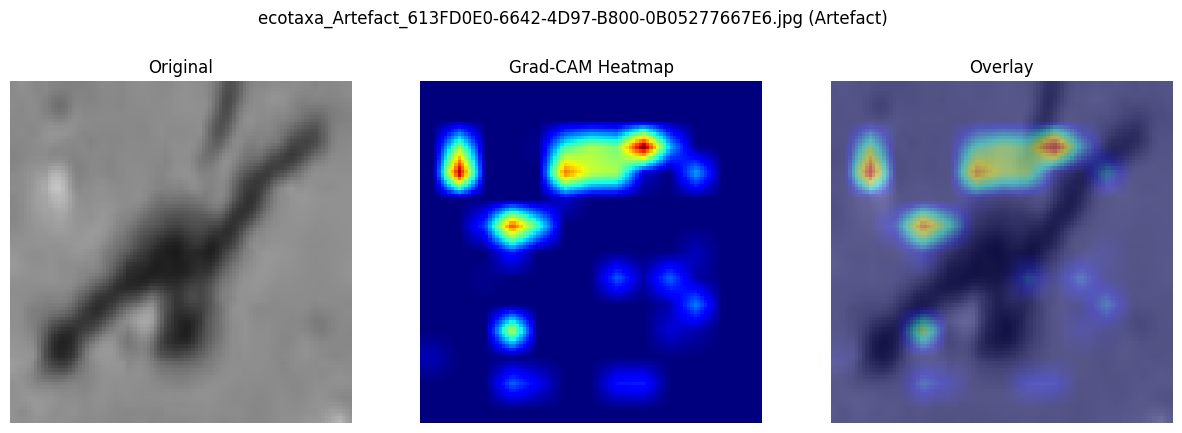

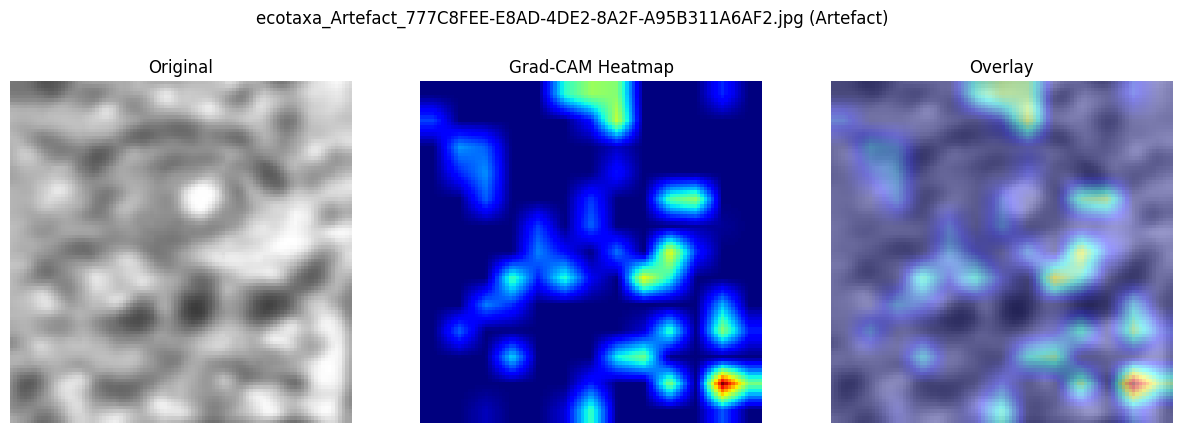

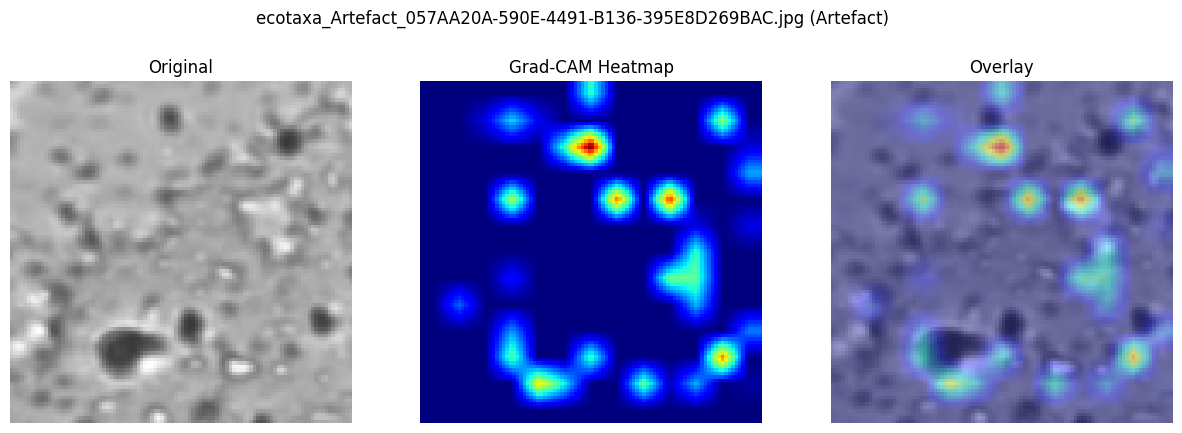

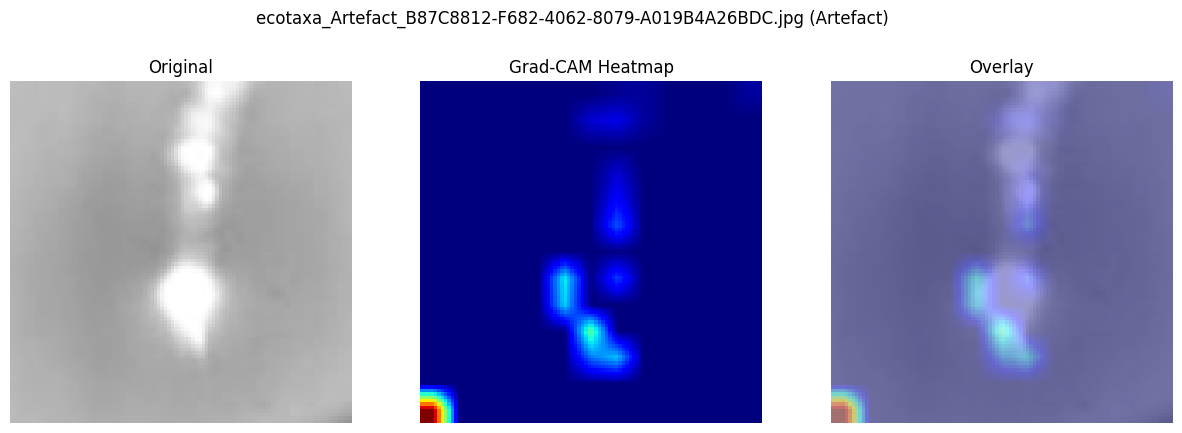

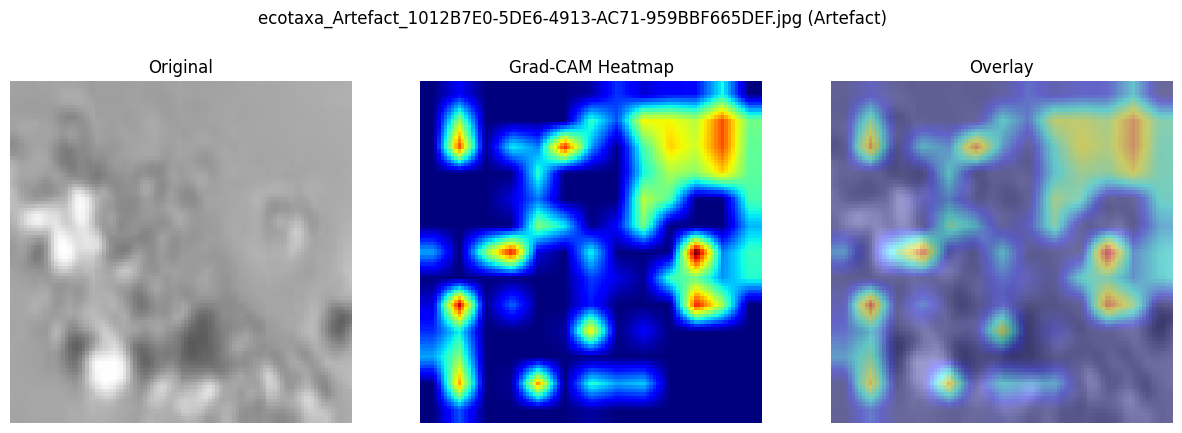

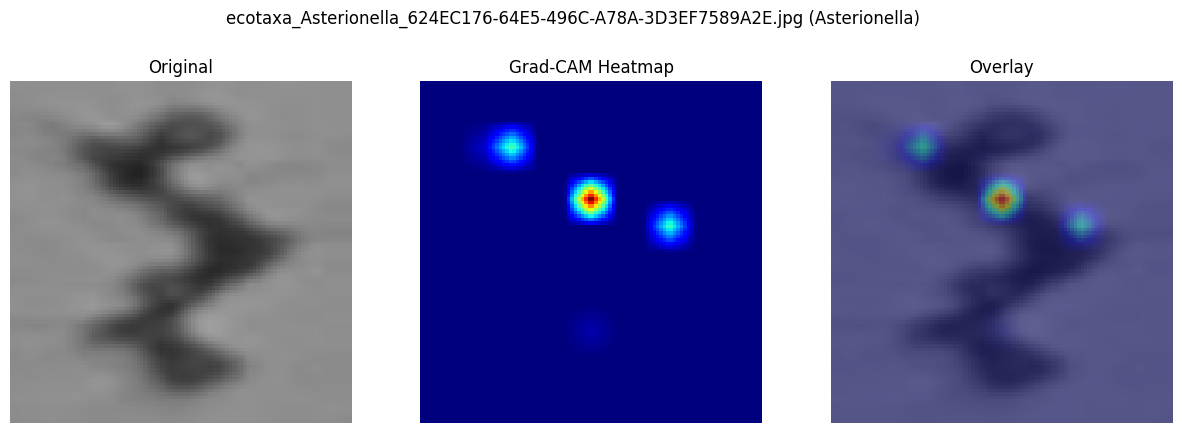

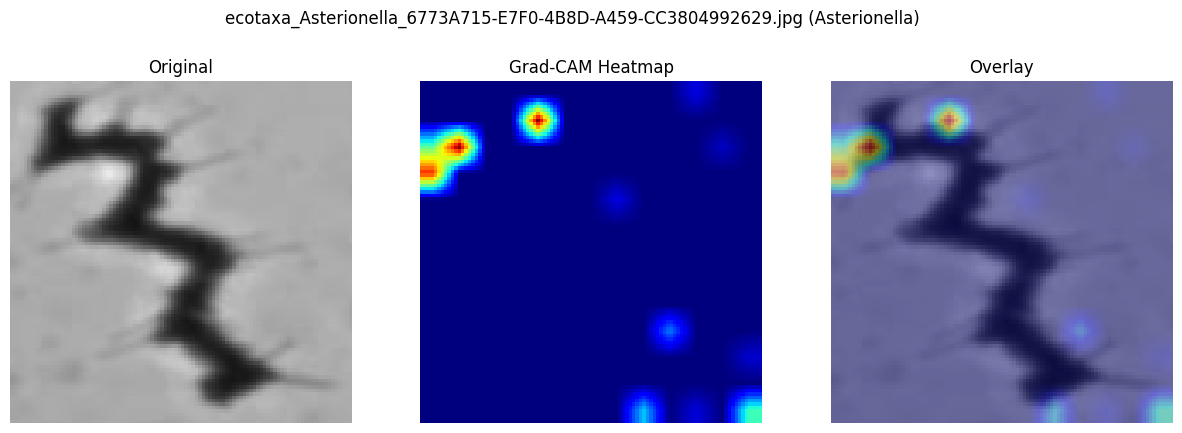

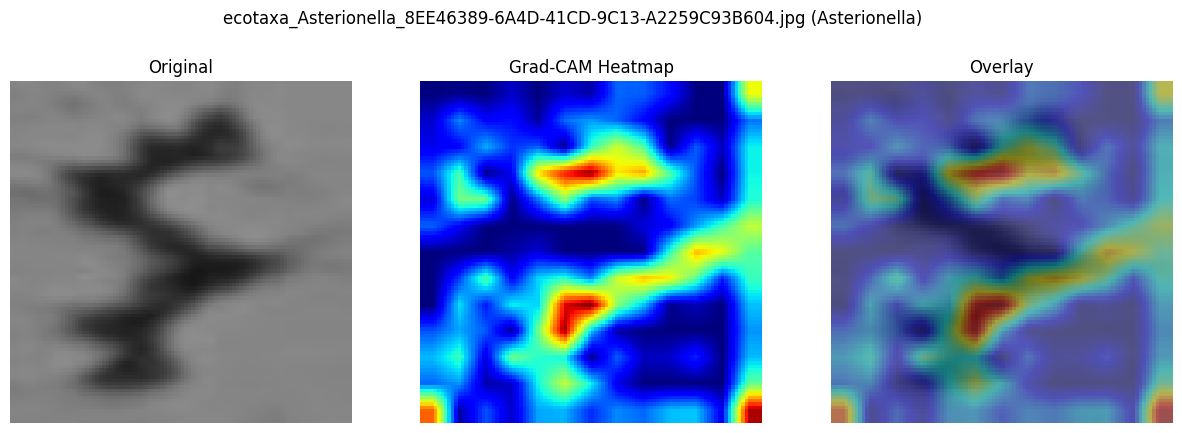

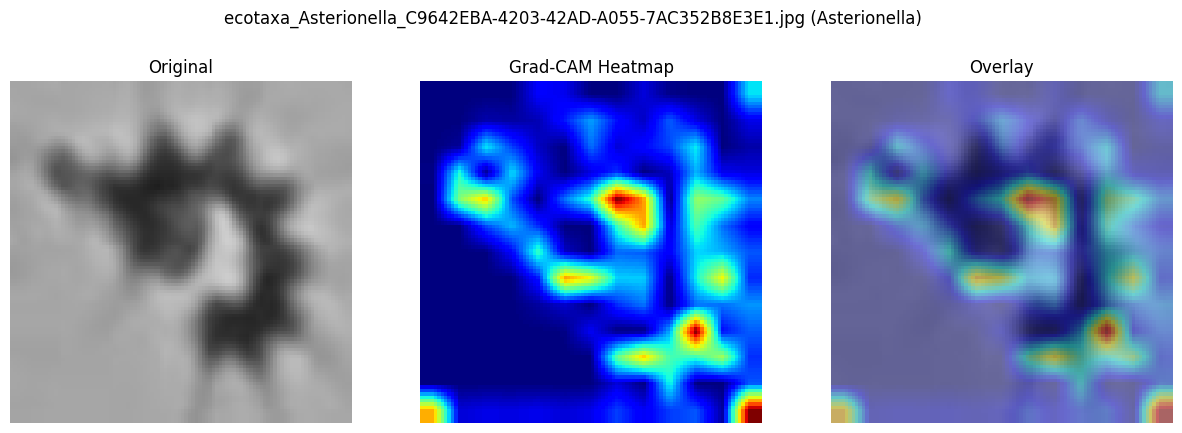

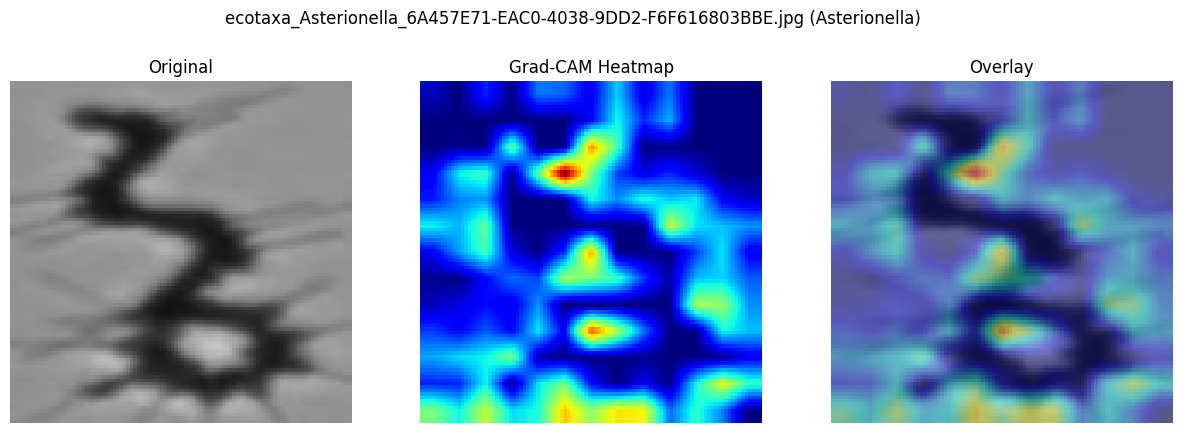

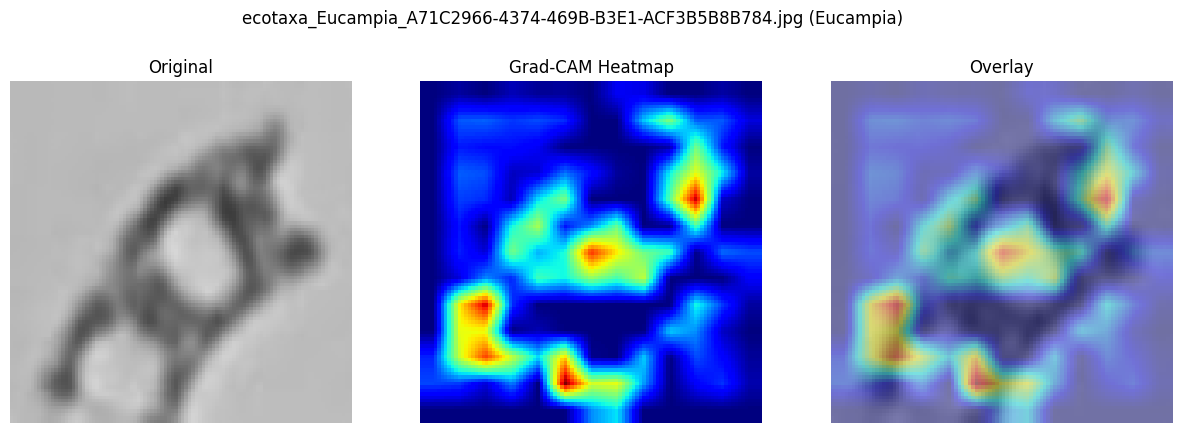

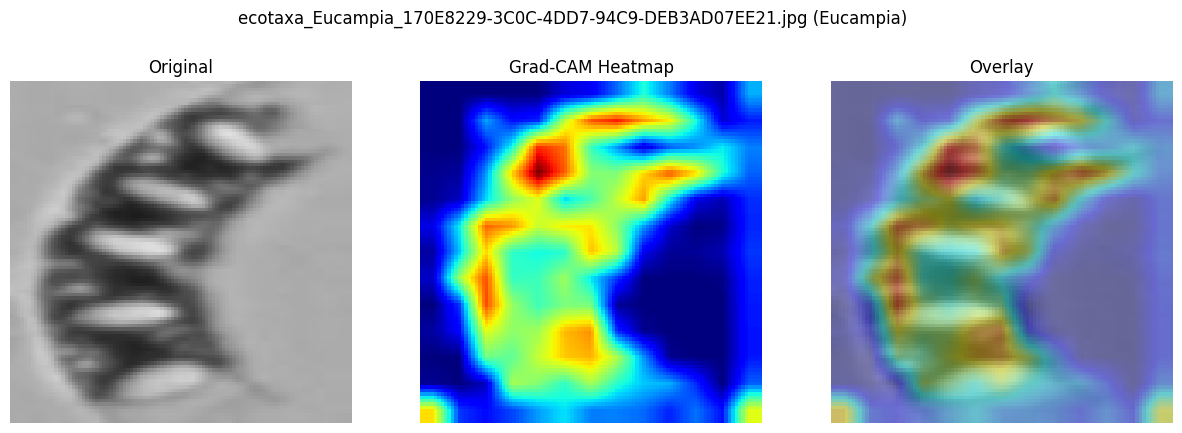

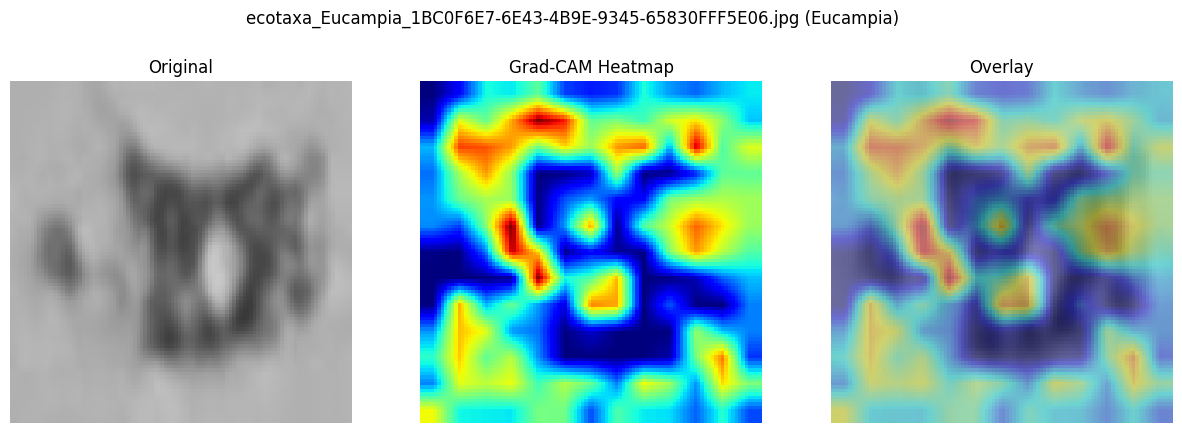

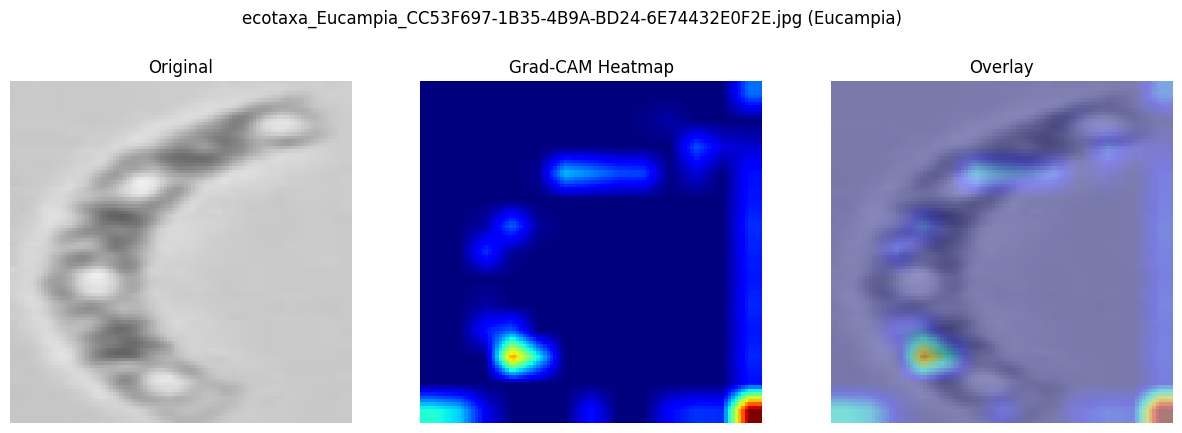

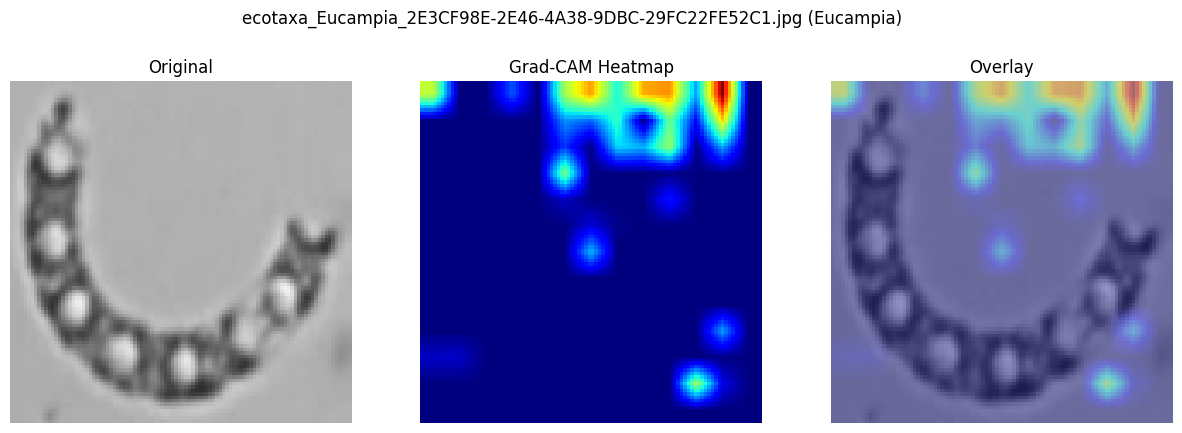

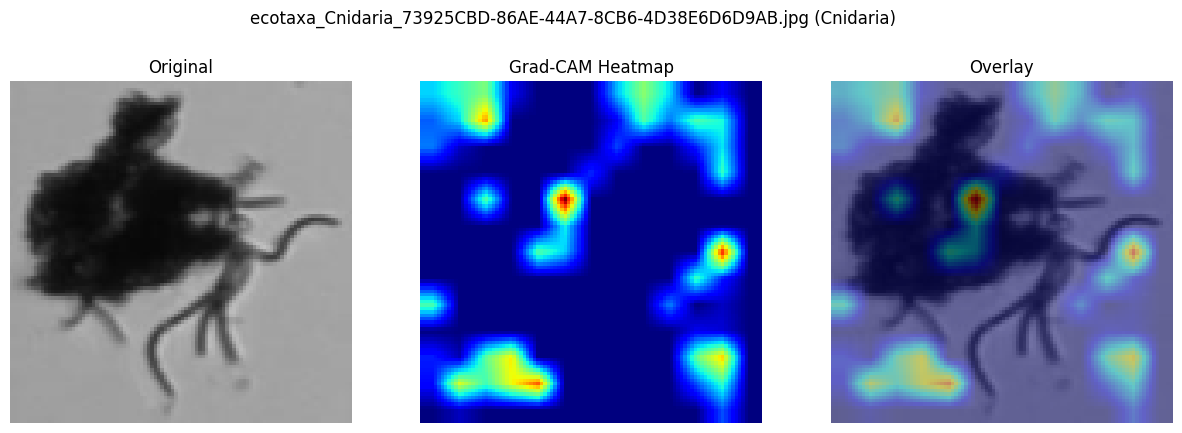

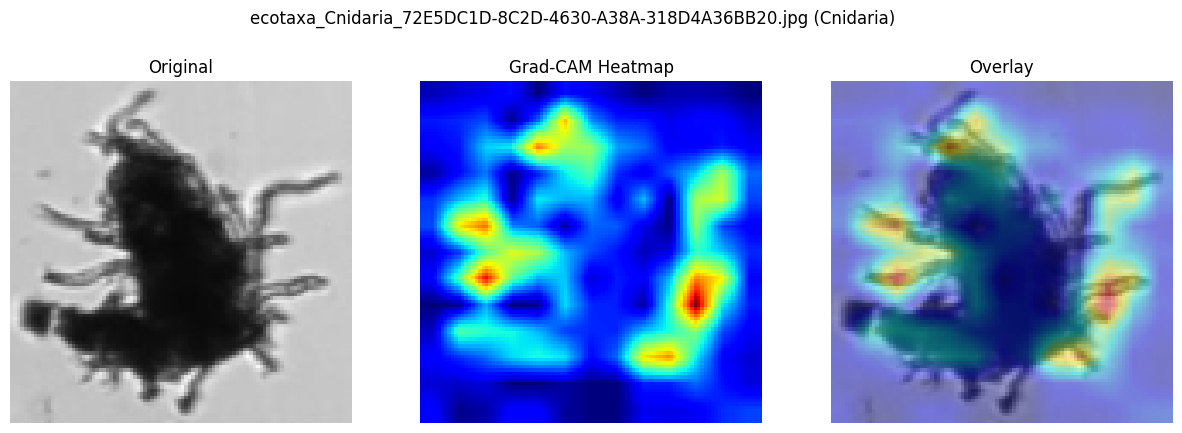

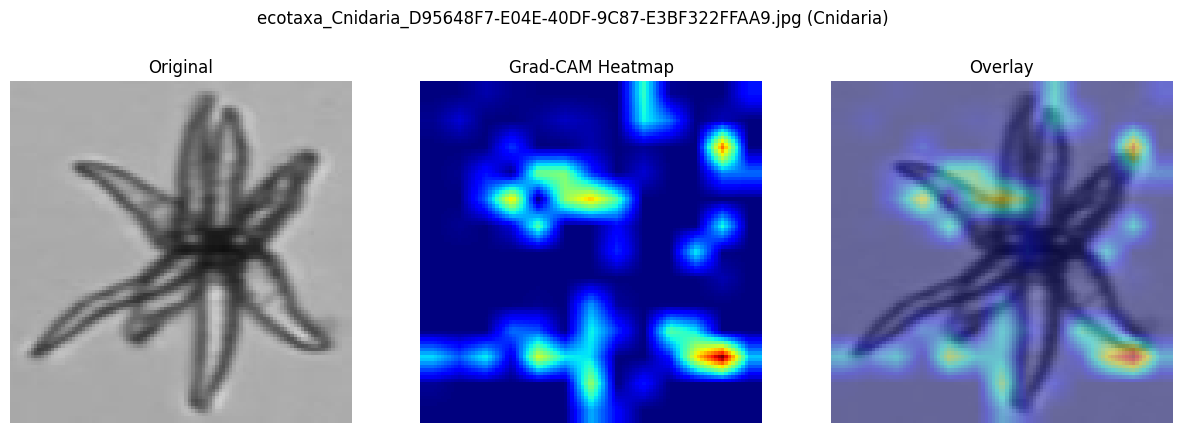

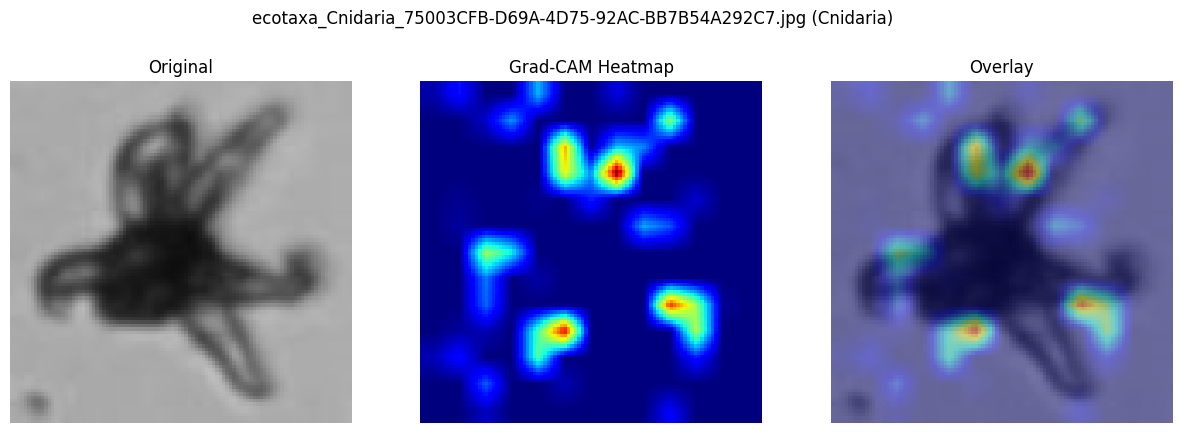

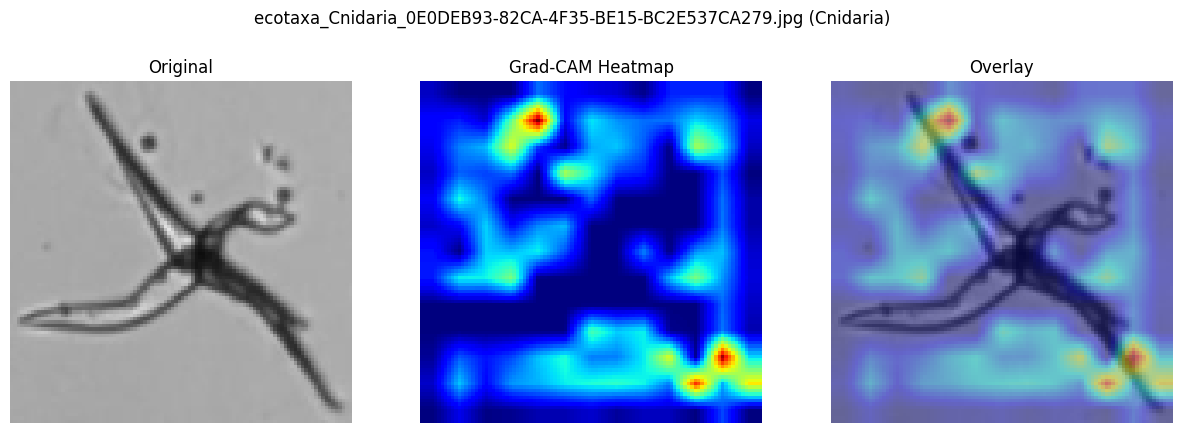

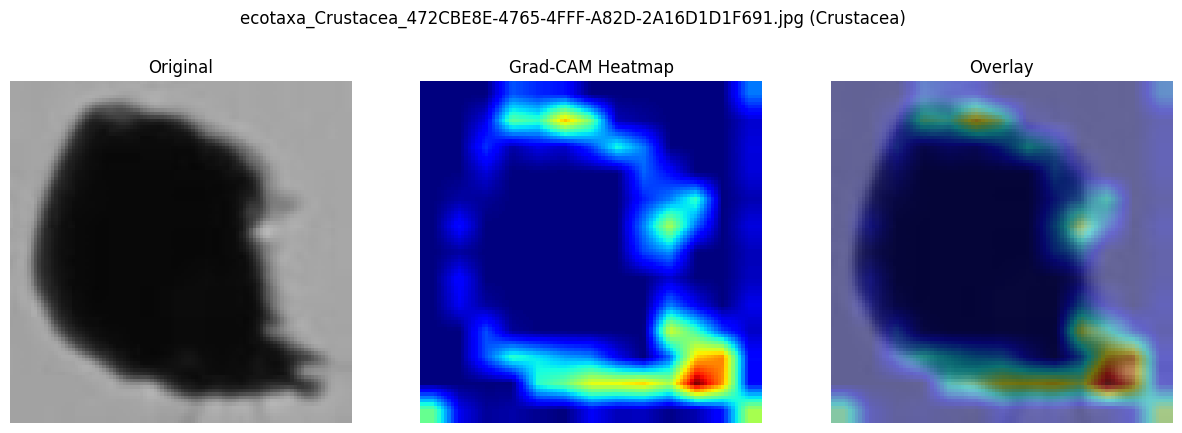

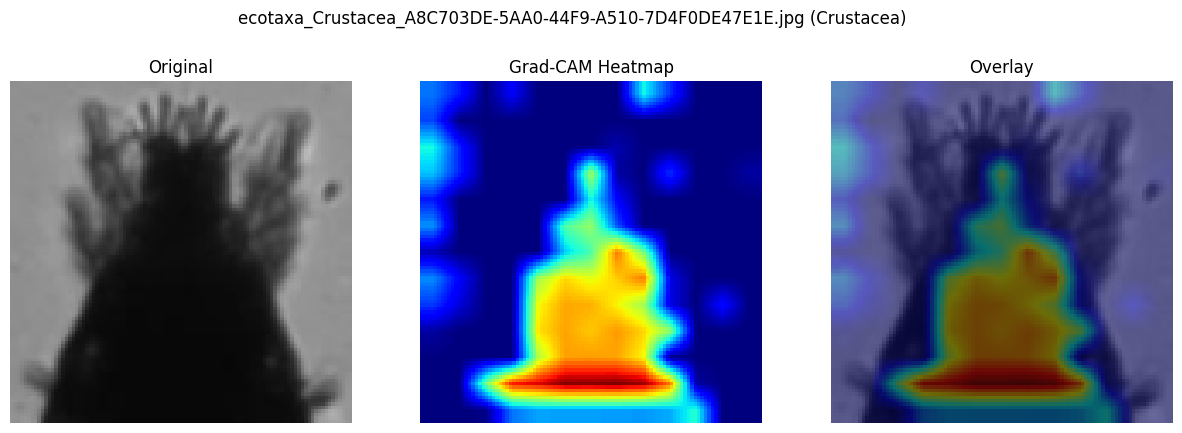

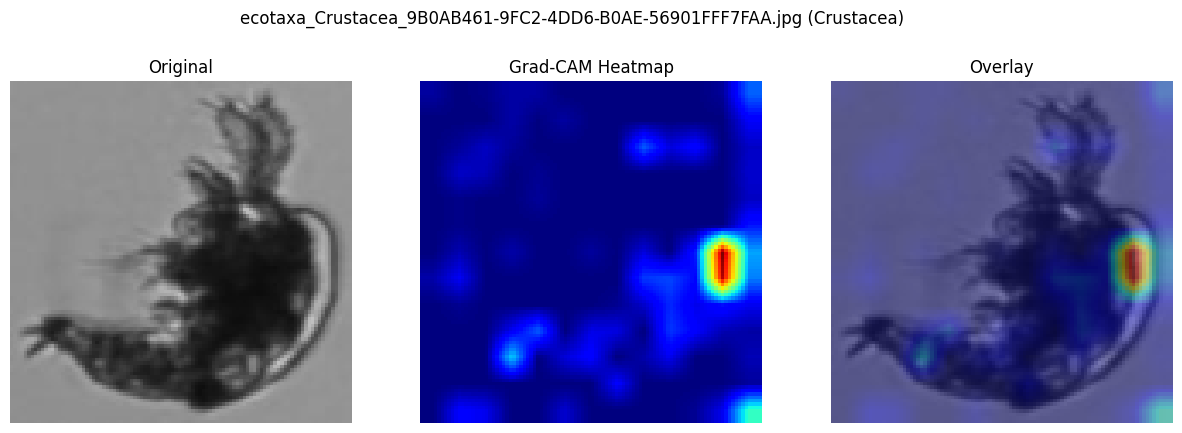

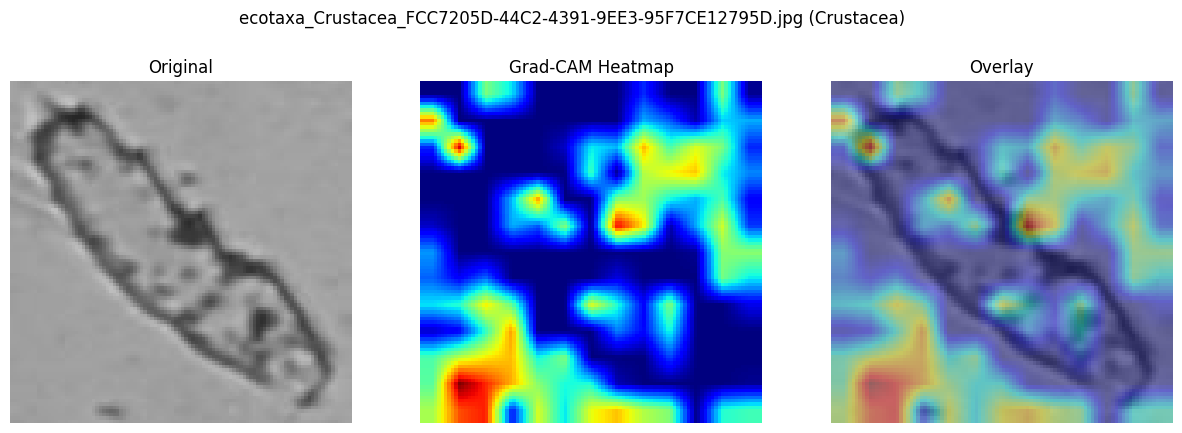

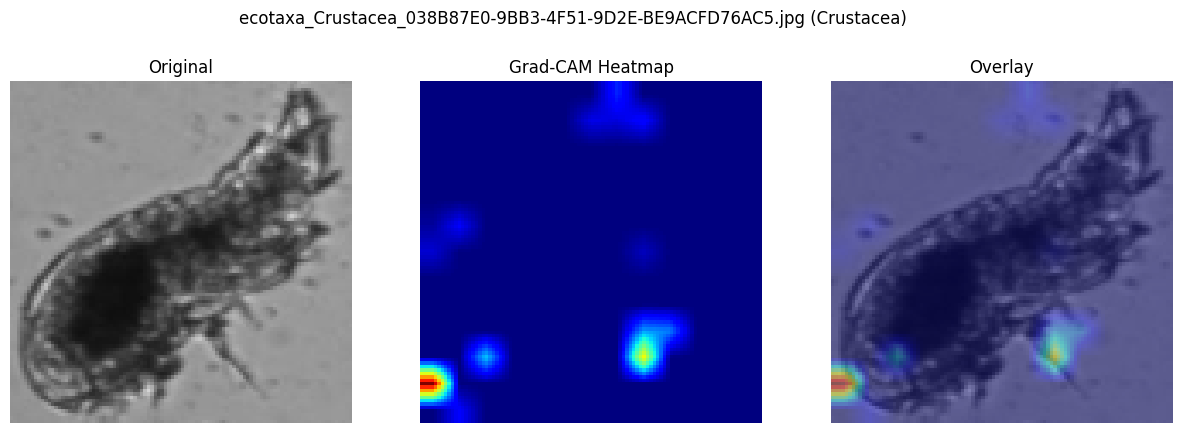

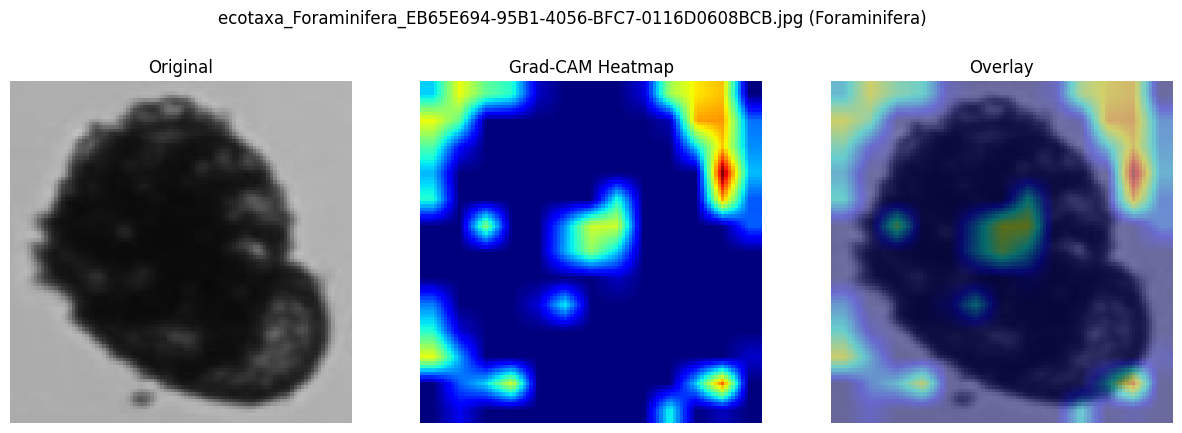

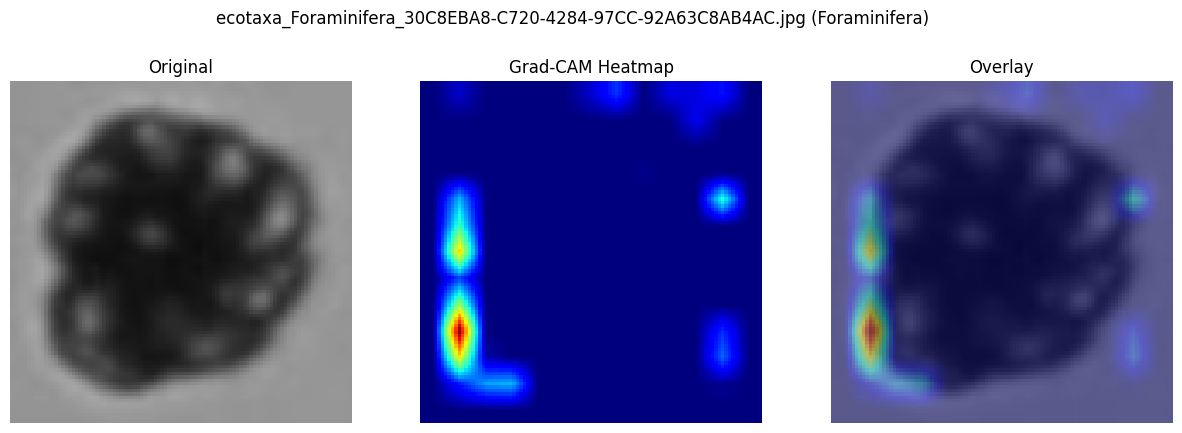

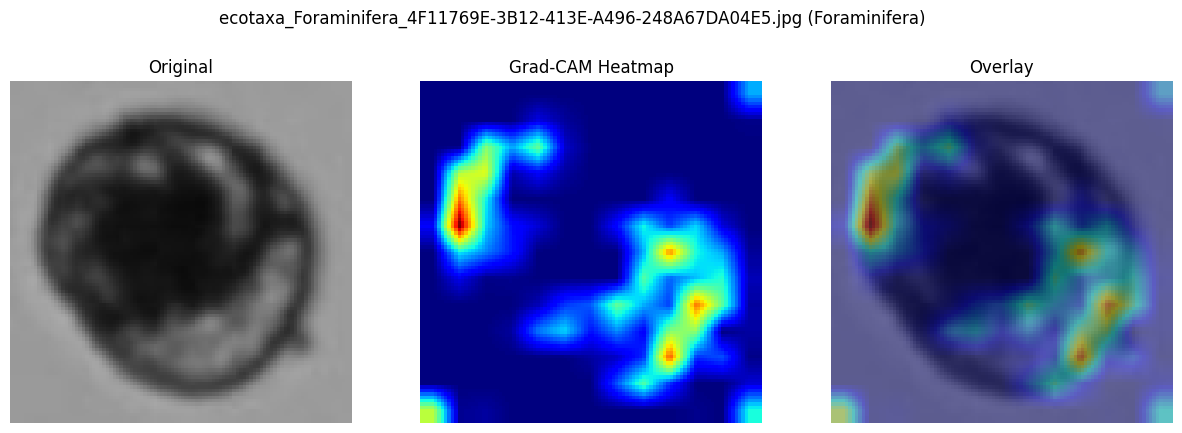

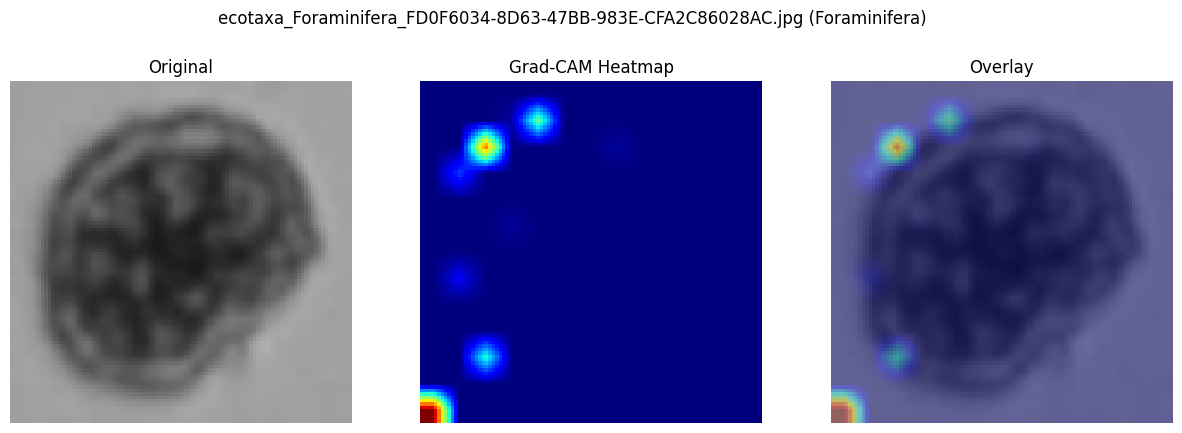

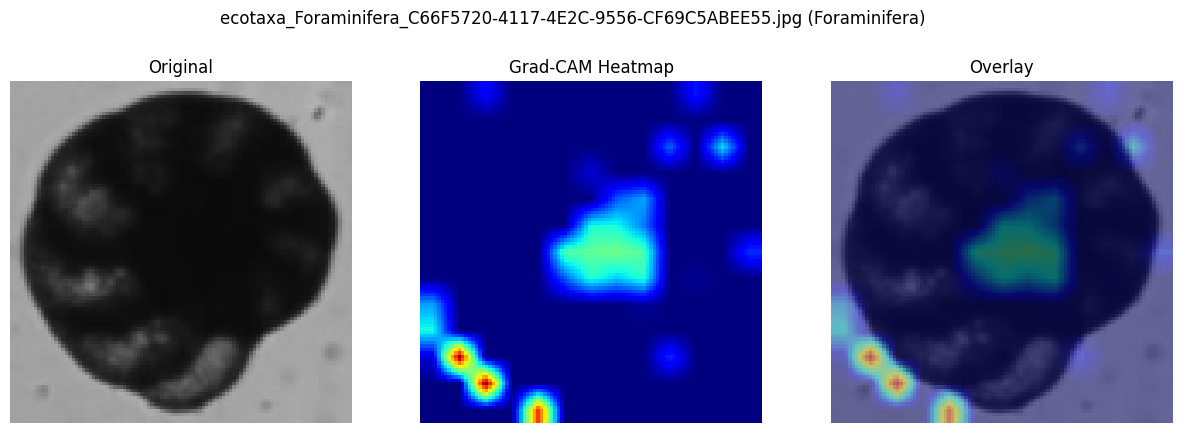

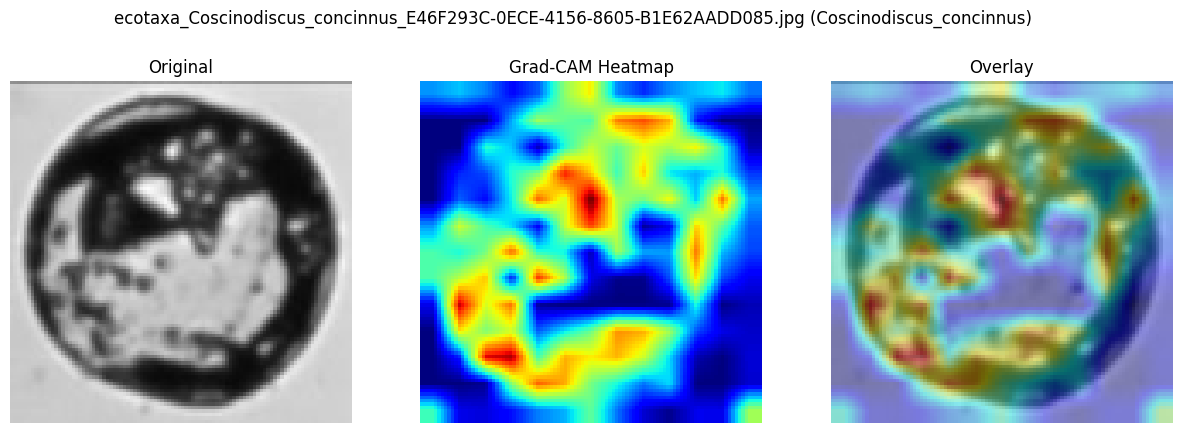

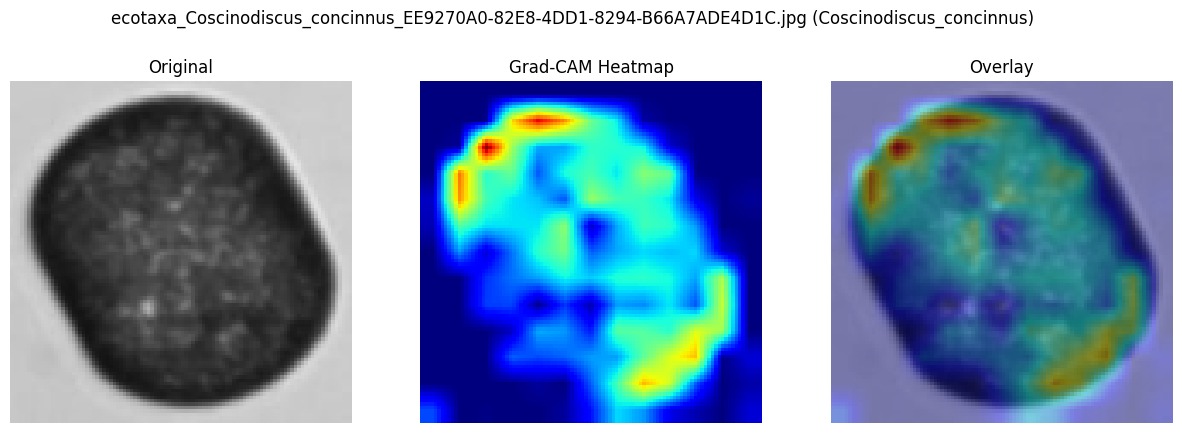

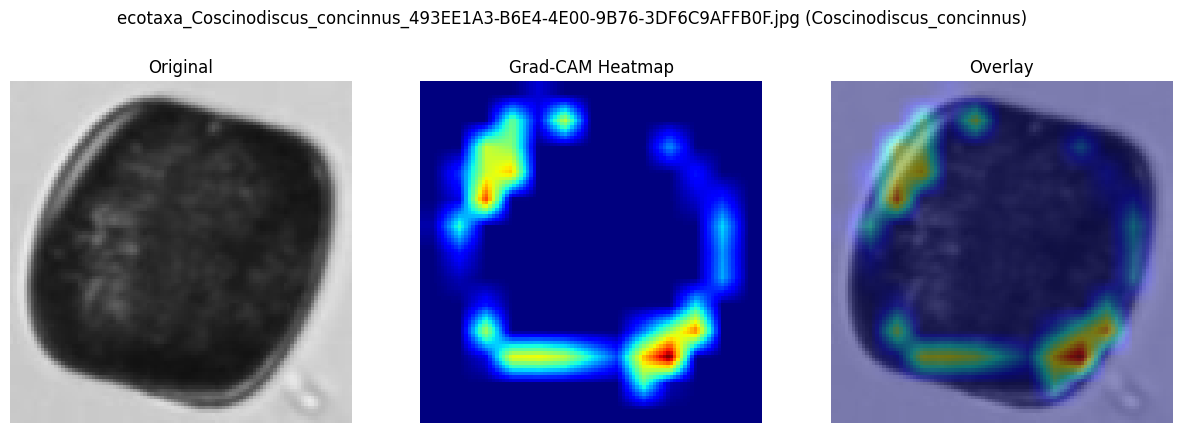

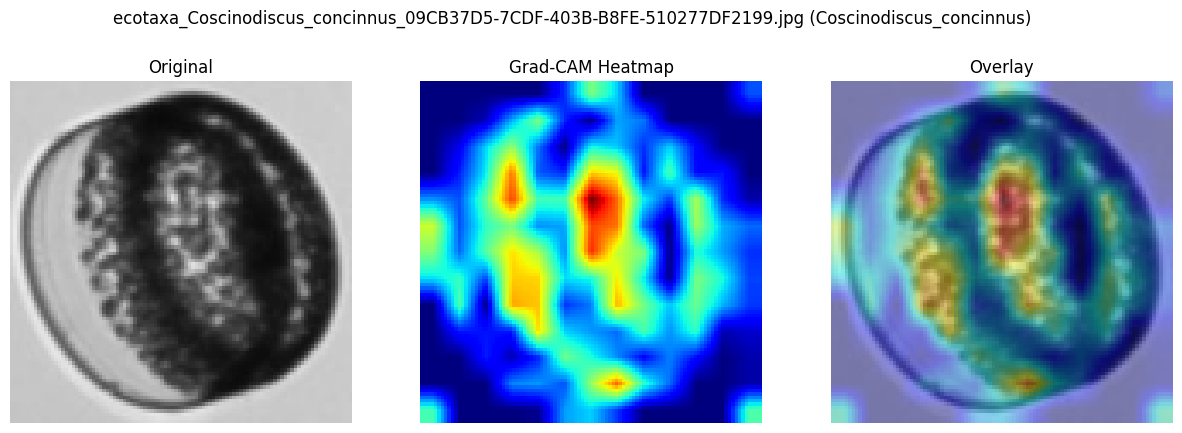

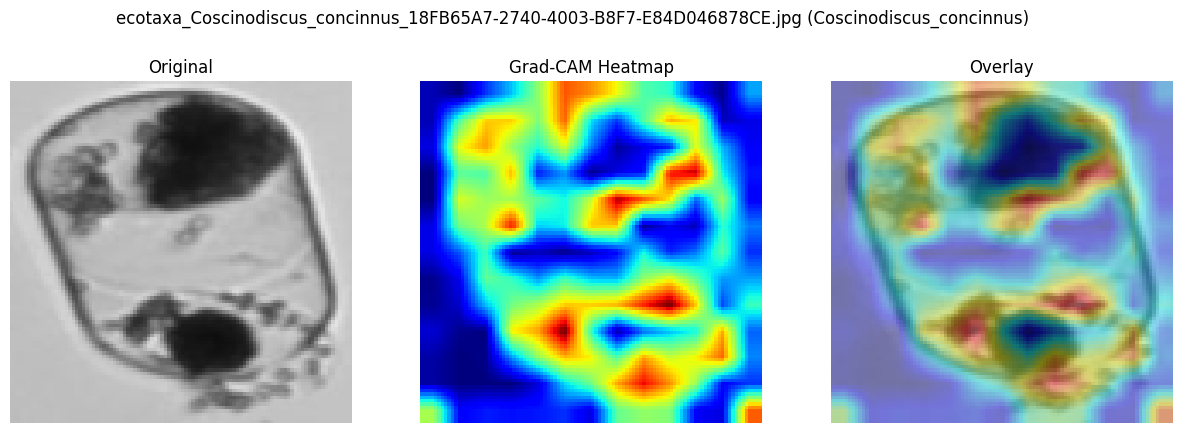

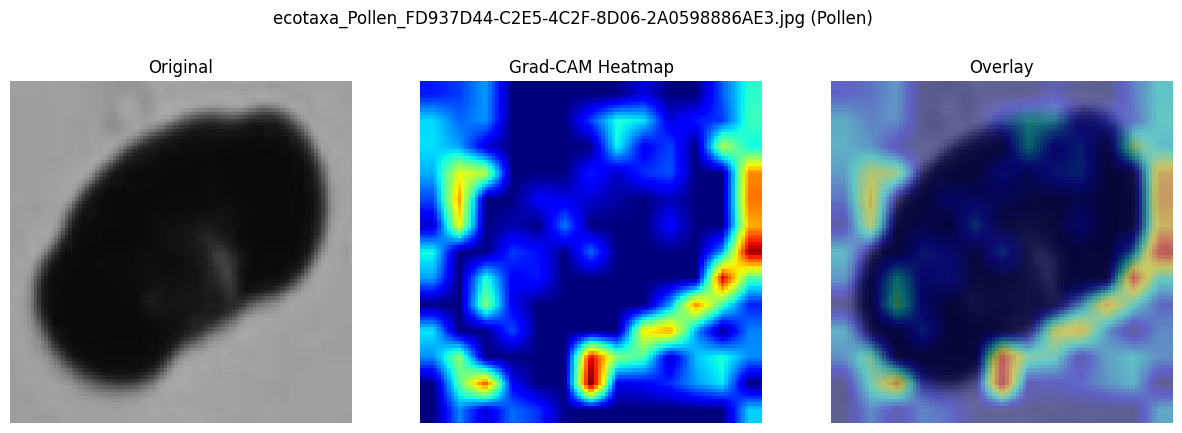

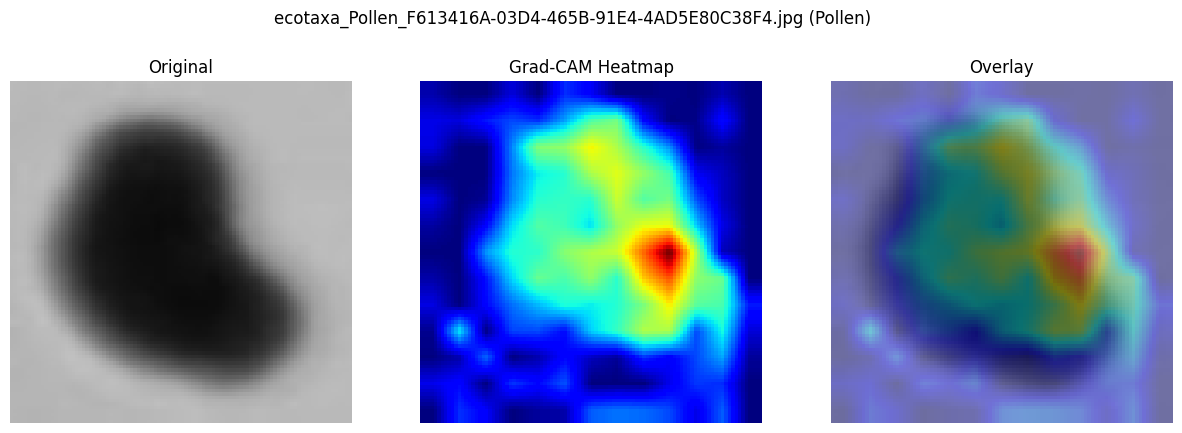

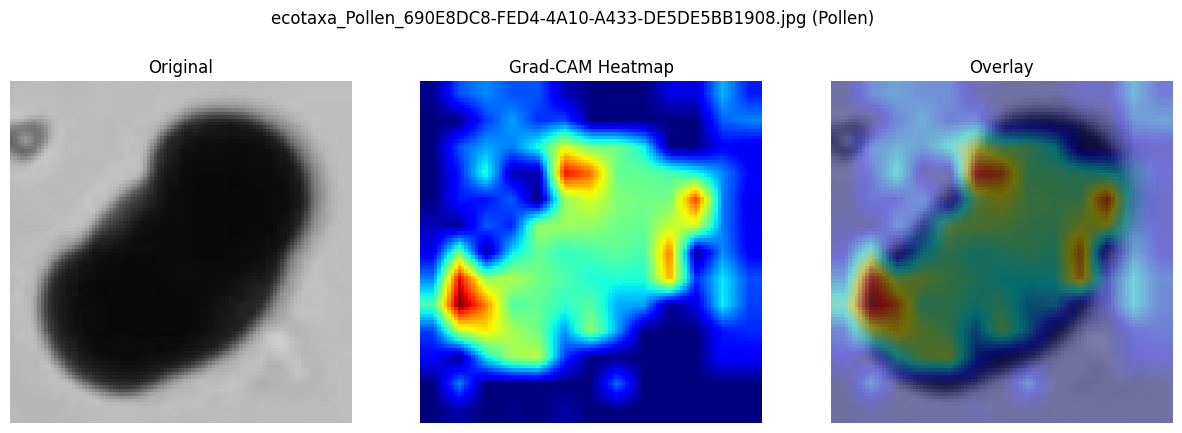

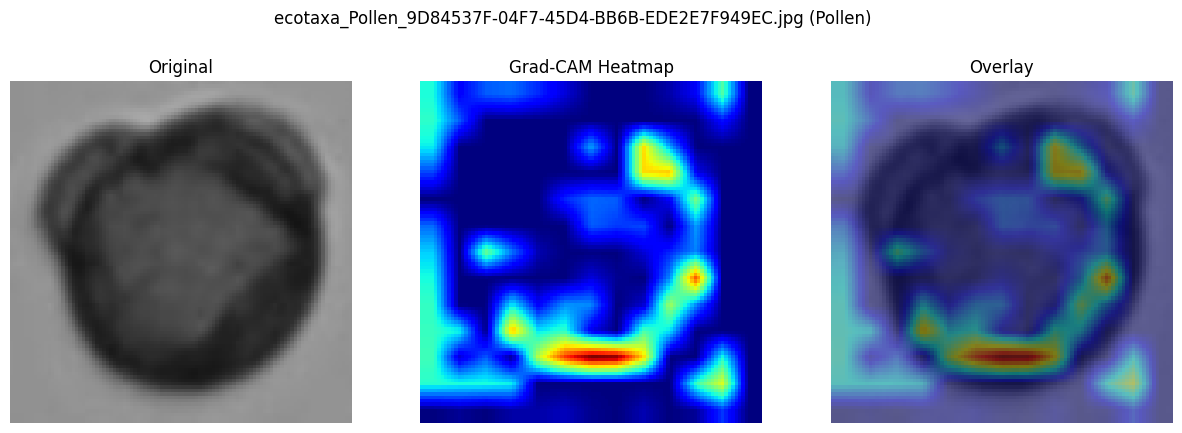

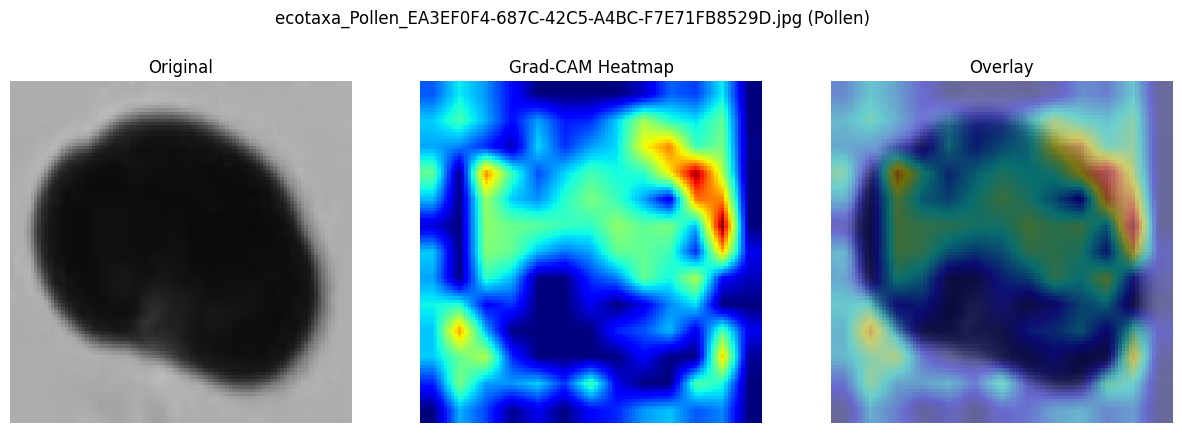

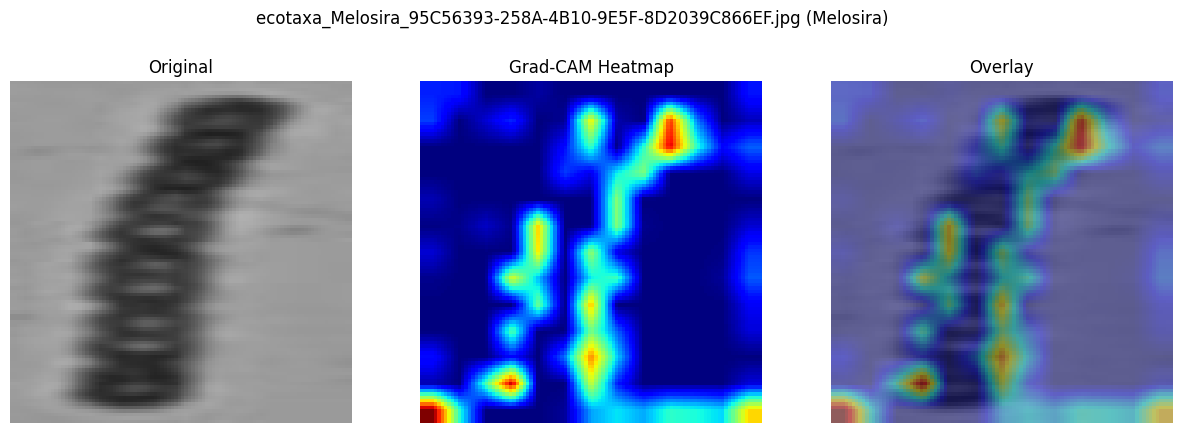

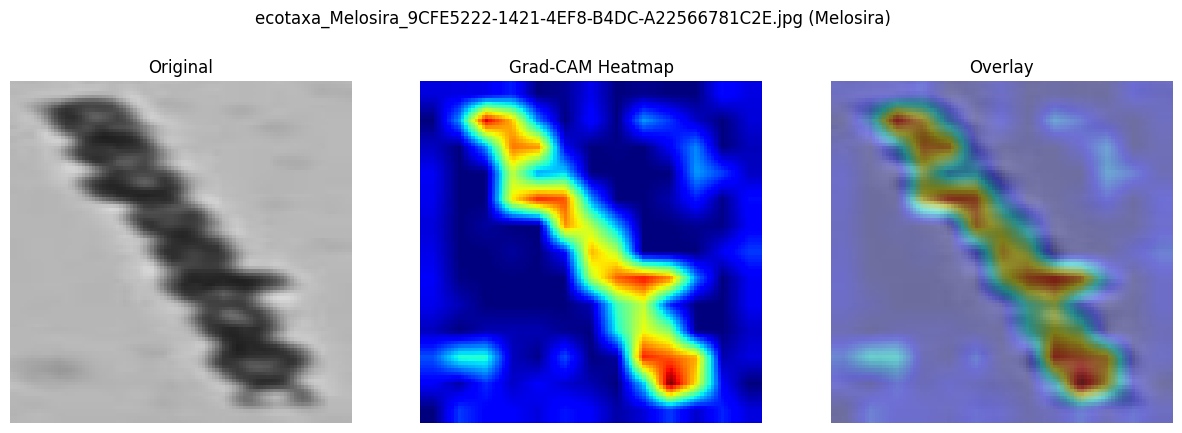

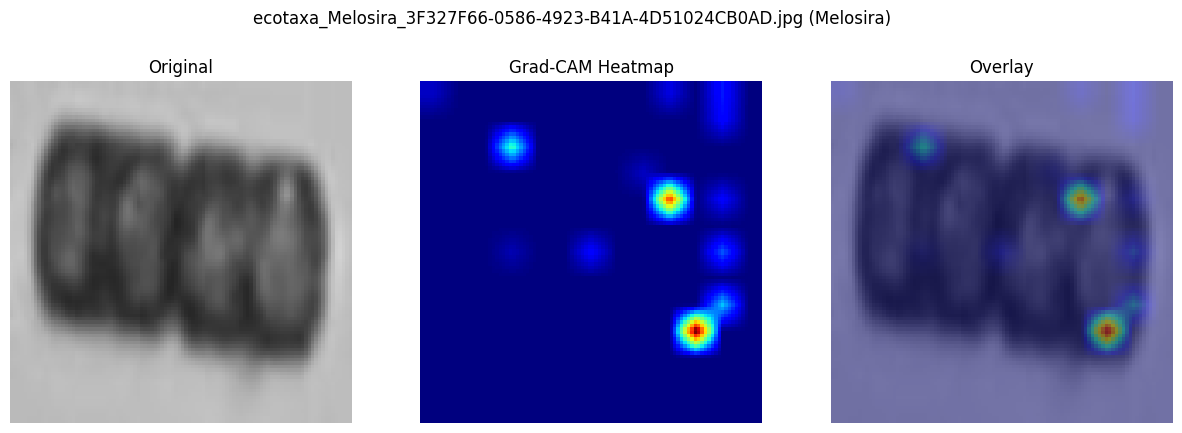

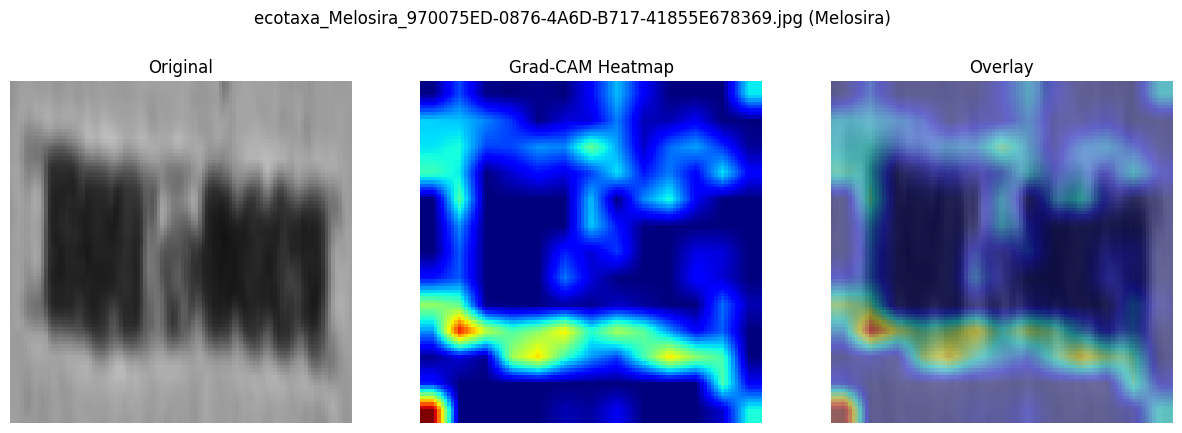

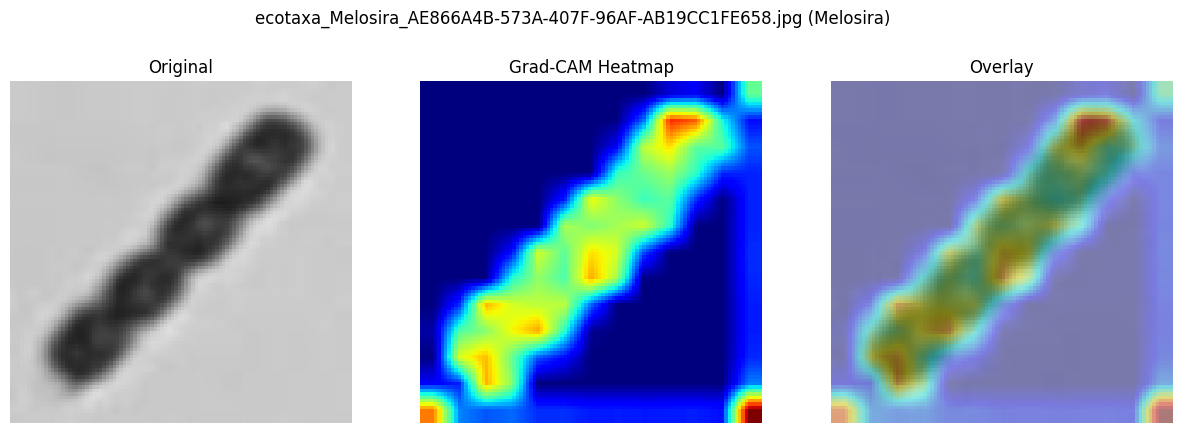

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

from planktonclas import paths, utils, data_utils
from planktonclas.data_utils import k_crop_data_sequence

# ---- USER INPUTS ----
DATA_DIR = r"\\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist"
MODEL_NAME = 'final_model.h5'
TIMESTAMP = 'Phytoplankton_EfficientNetV2B0'
LAYER_NAME = "block3a_expand_conv"

# Classes suggested in discussion
PRIORITY_CLASSES = [
    'Artefact', 'Asterionella', 'Eucampia',
    'Cnidaria', 'Crustacea', 'Foraminifera',
    'Coscinodiscus_concinnus', 'Pollen', 'Melosira'
]
NUM_PER_CLASS = 5  # number of random images per class

# ---- LOAD CONFIG ----
paths.timestamp = TIMESTAMP
import json
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)

# ---- LOAD MODEL ----
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects())

# ---- HELPER FUNCTIONS ----
def load_random_images_from_classes(data_dir, classes, num_per_class=2):
    selected_files = []
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        if not os.path.exists(class_dir):
            continue
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        selected_files.extend(random.sample(files, min(num_per_class, len(files))))
    return selected_files

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ---- PROCESS IMAGES ----
sample_files = load_random_images_from_classes(DATA_DIR, PRIORITY_CLASSES, NUM_PER_CLASS)


In [ ]:

for img_path in sample_files:
    # Preprocess image
    data_gen = k_crop_data_sequence(
        inputs=[img_path],
        im_size=conf['model']['image_size'],
        mean_RGB=conf['dataset']['mean_RGB'],
        std_RGB=conf['dataset']['std_RGB'],
        preprocess_mode=conf['model']['preprocess_mode'],
        aug_params=None,
        crop_mode='random',
        crop_number=1,
        filemode='local'
    )
    img_arr = data_gen.__getitem__(0).squeeze(axis=0)
    
    # Load original for overlay
    image = data_utils.load_image(img_path, filemode='local')
    image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
    
    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_arr, model, LAYER_NAME)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)
    
    # Display results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    axs[1].imshow(heatmap_resized, cmap='jet')
    axs[1].set_title('Grad-CAM Heatmap')
    axs[1].axis('off')
    
    axs[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Overlay')
    axs[2].axis('off')
    
    plt.suptitle(f"{os.path.basename(img_path)} ({os.path.basename(os.path.dirname(img_path))})")
    plt.show()


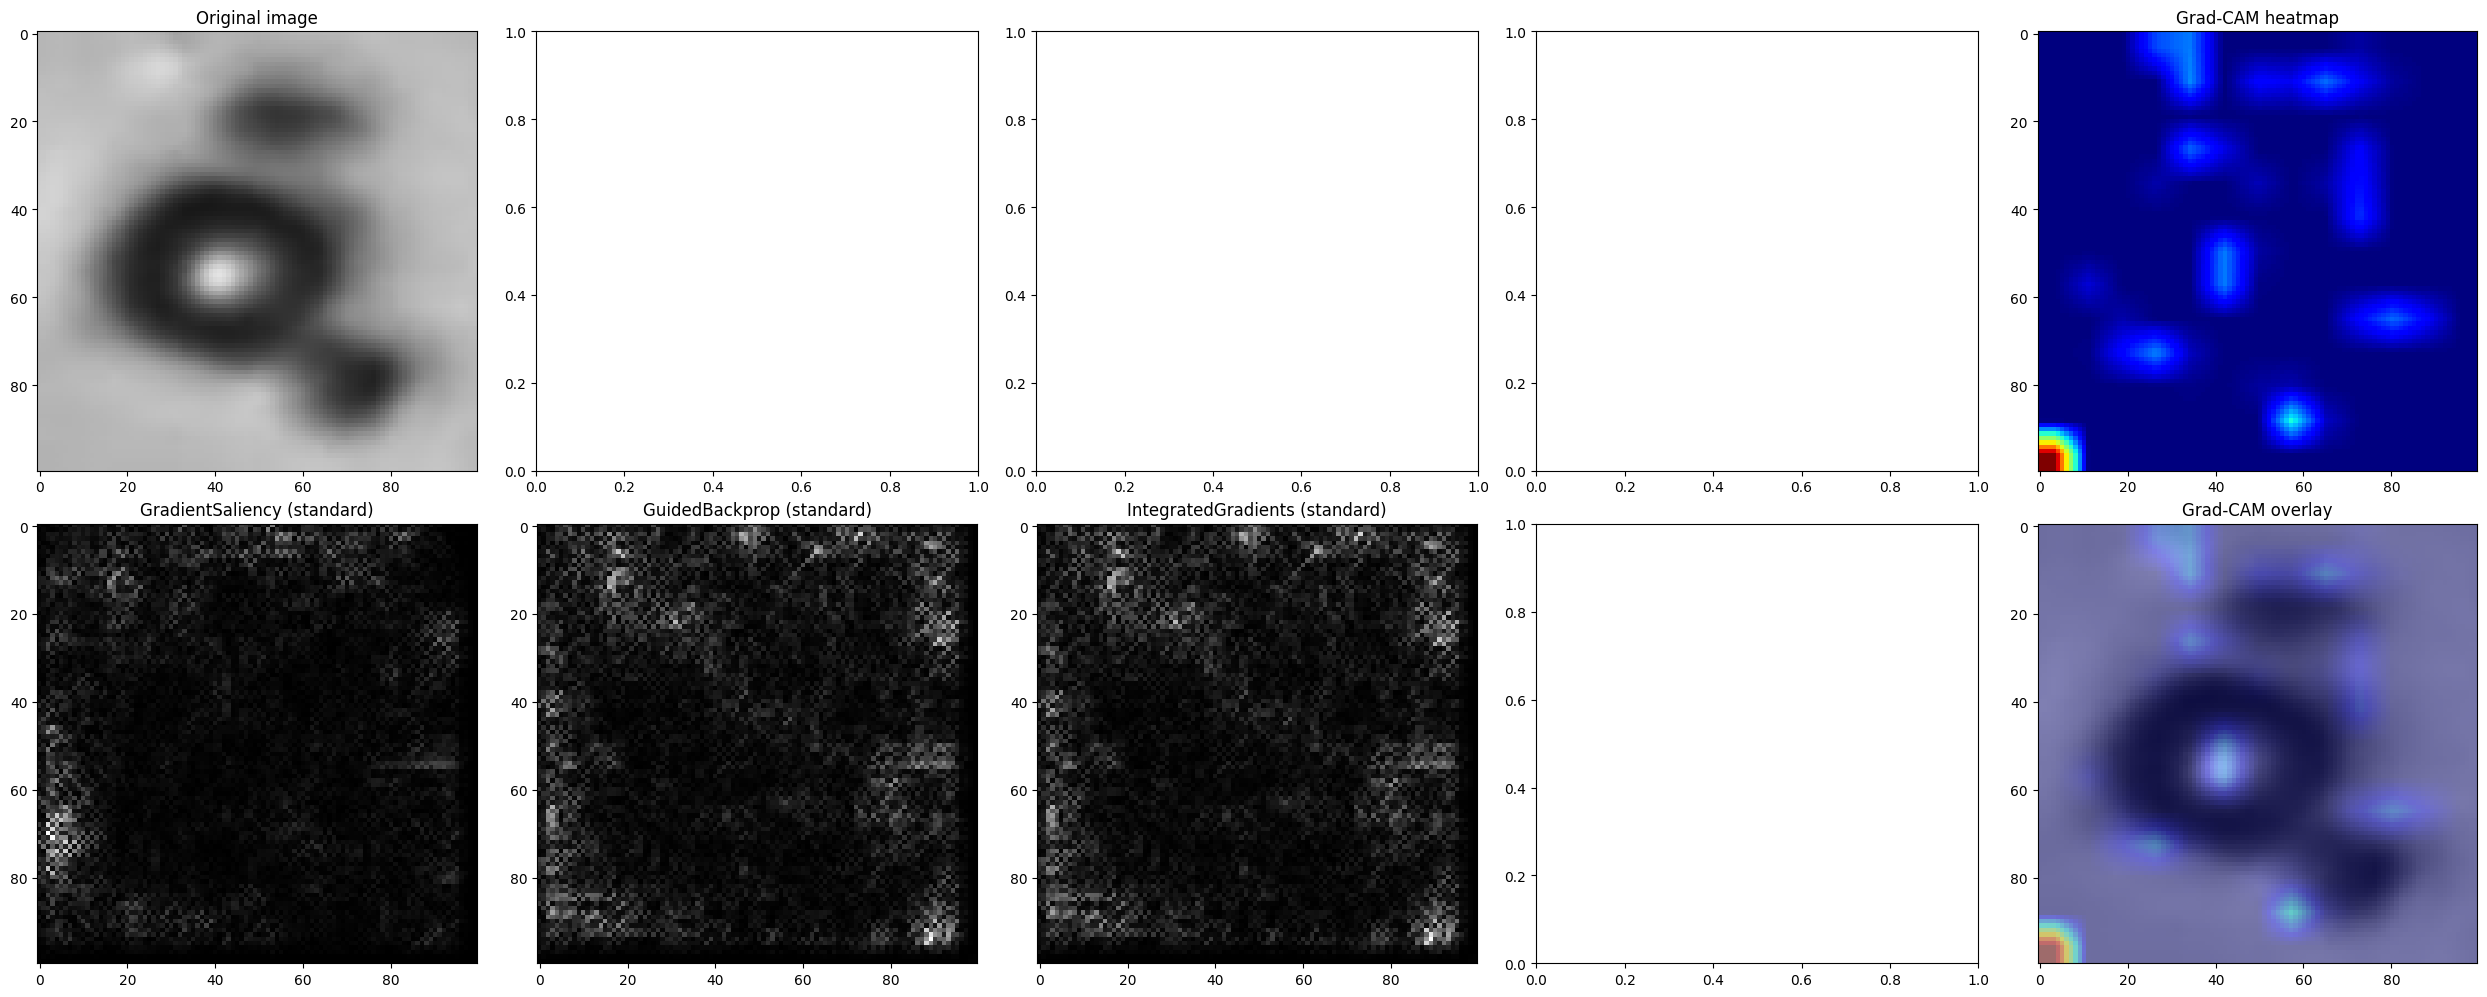

Processed: \\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist\Artefact\ecotaxa_Artefact_7558CE12-B078-4CDE-A6DF-292B3264358F.jpg


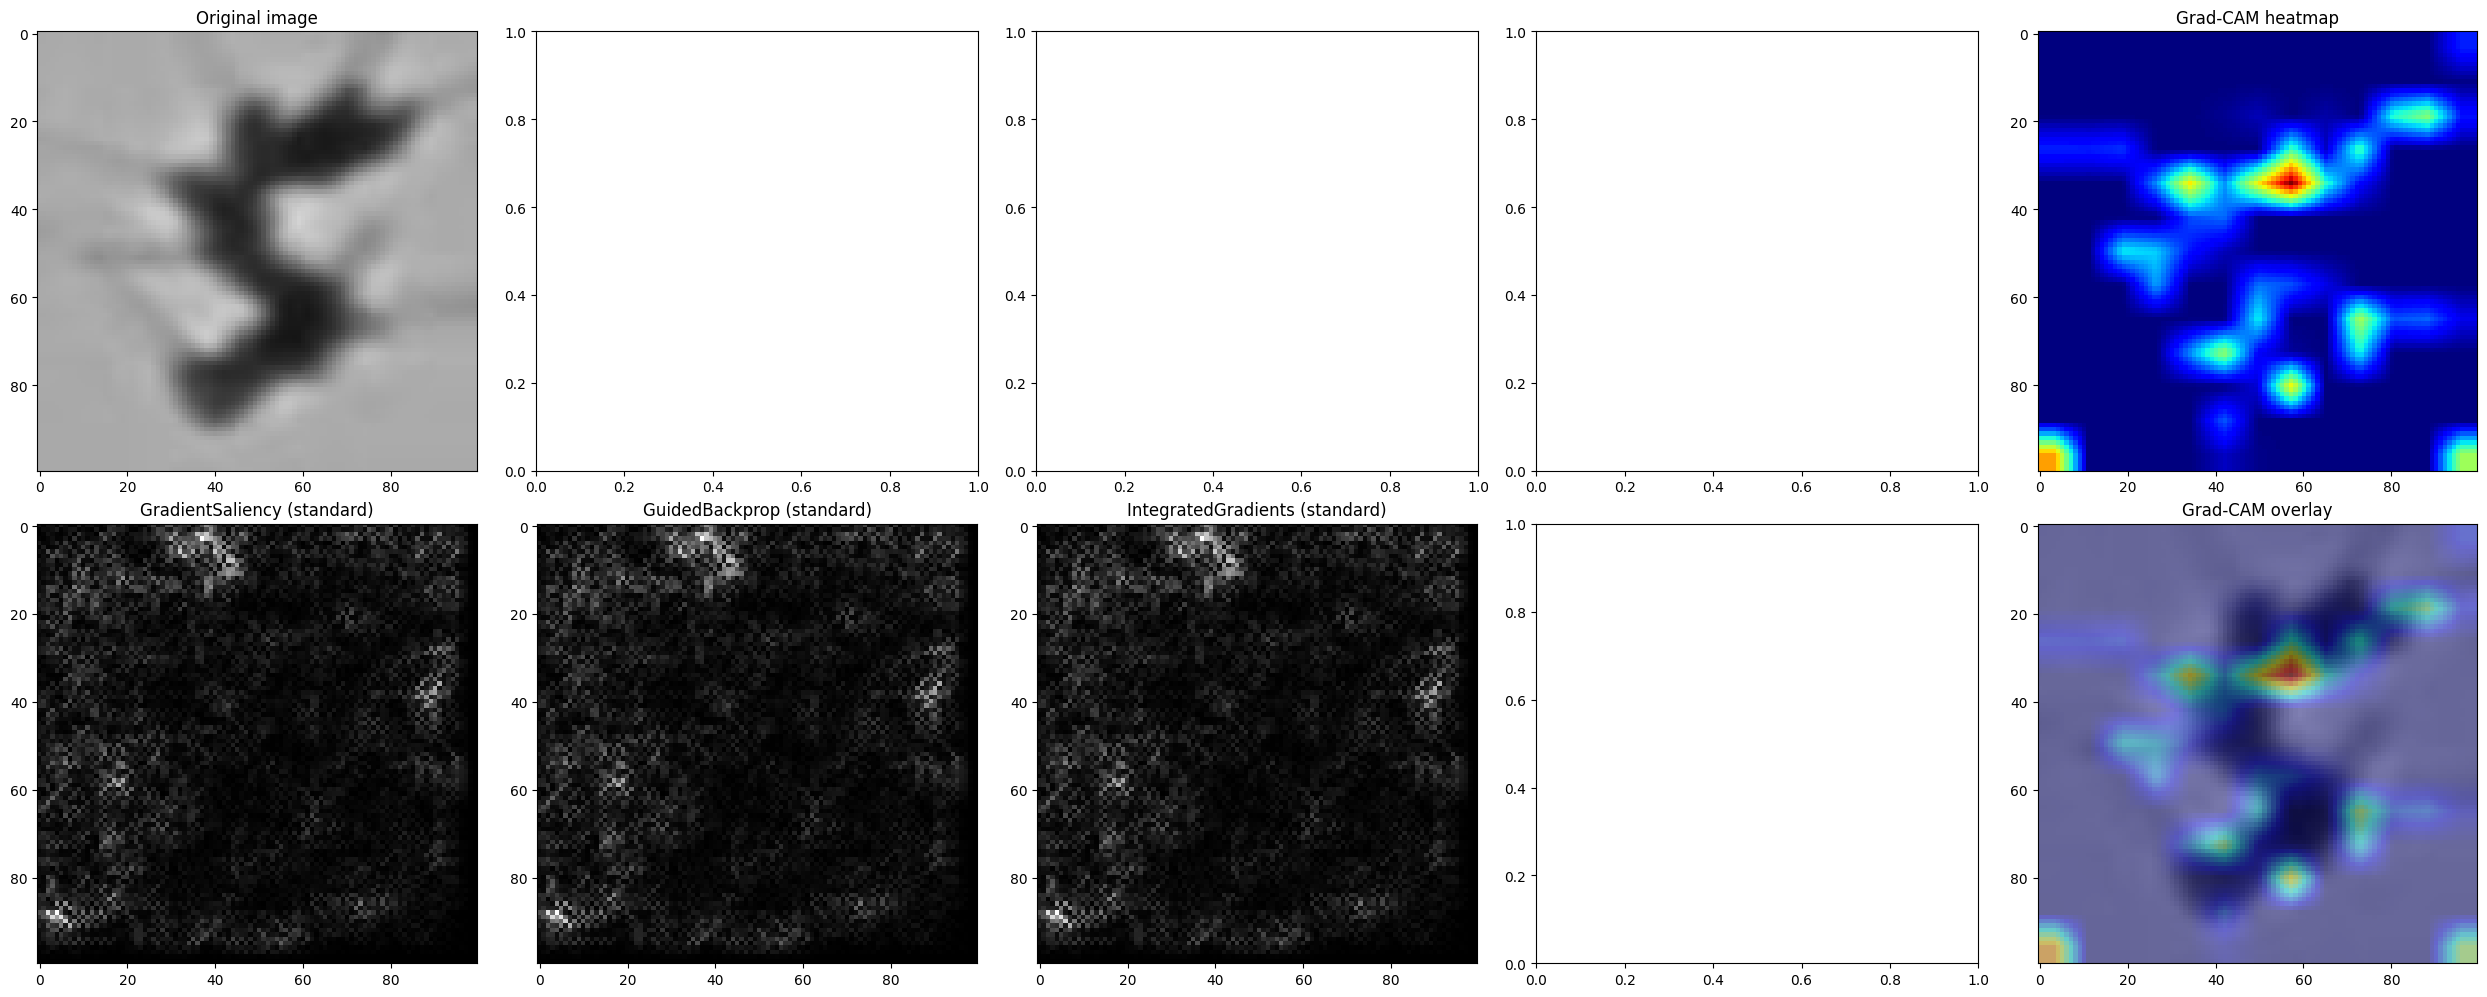

Processed: \\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist\Asterionella\ecotaxa_Asterionella_50F8DFB9-266A-4333-AA2D-2E9D7485DCCA.jpg


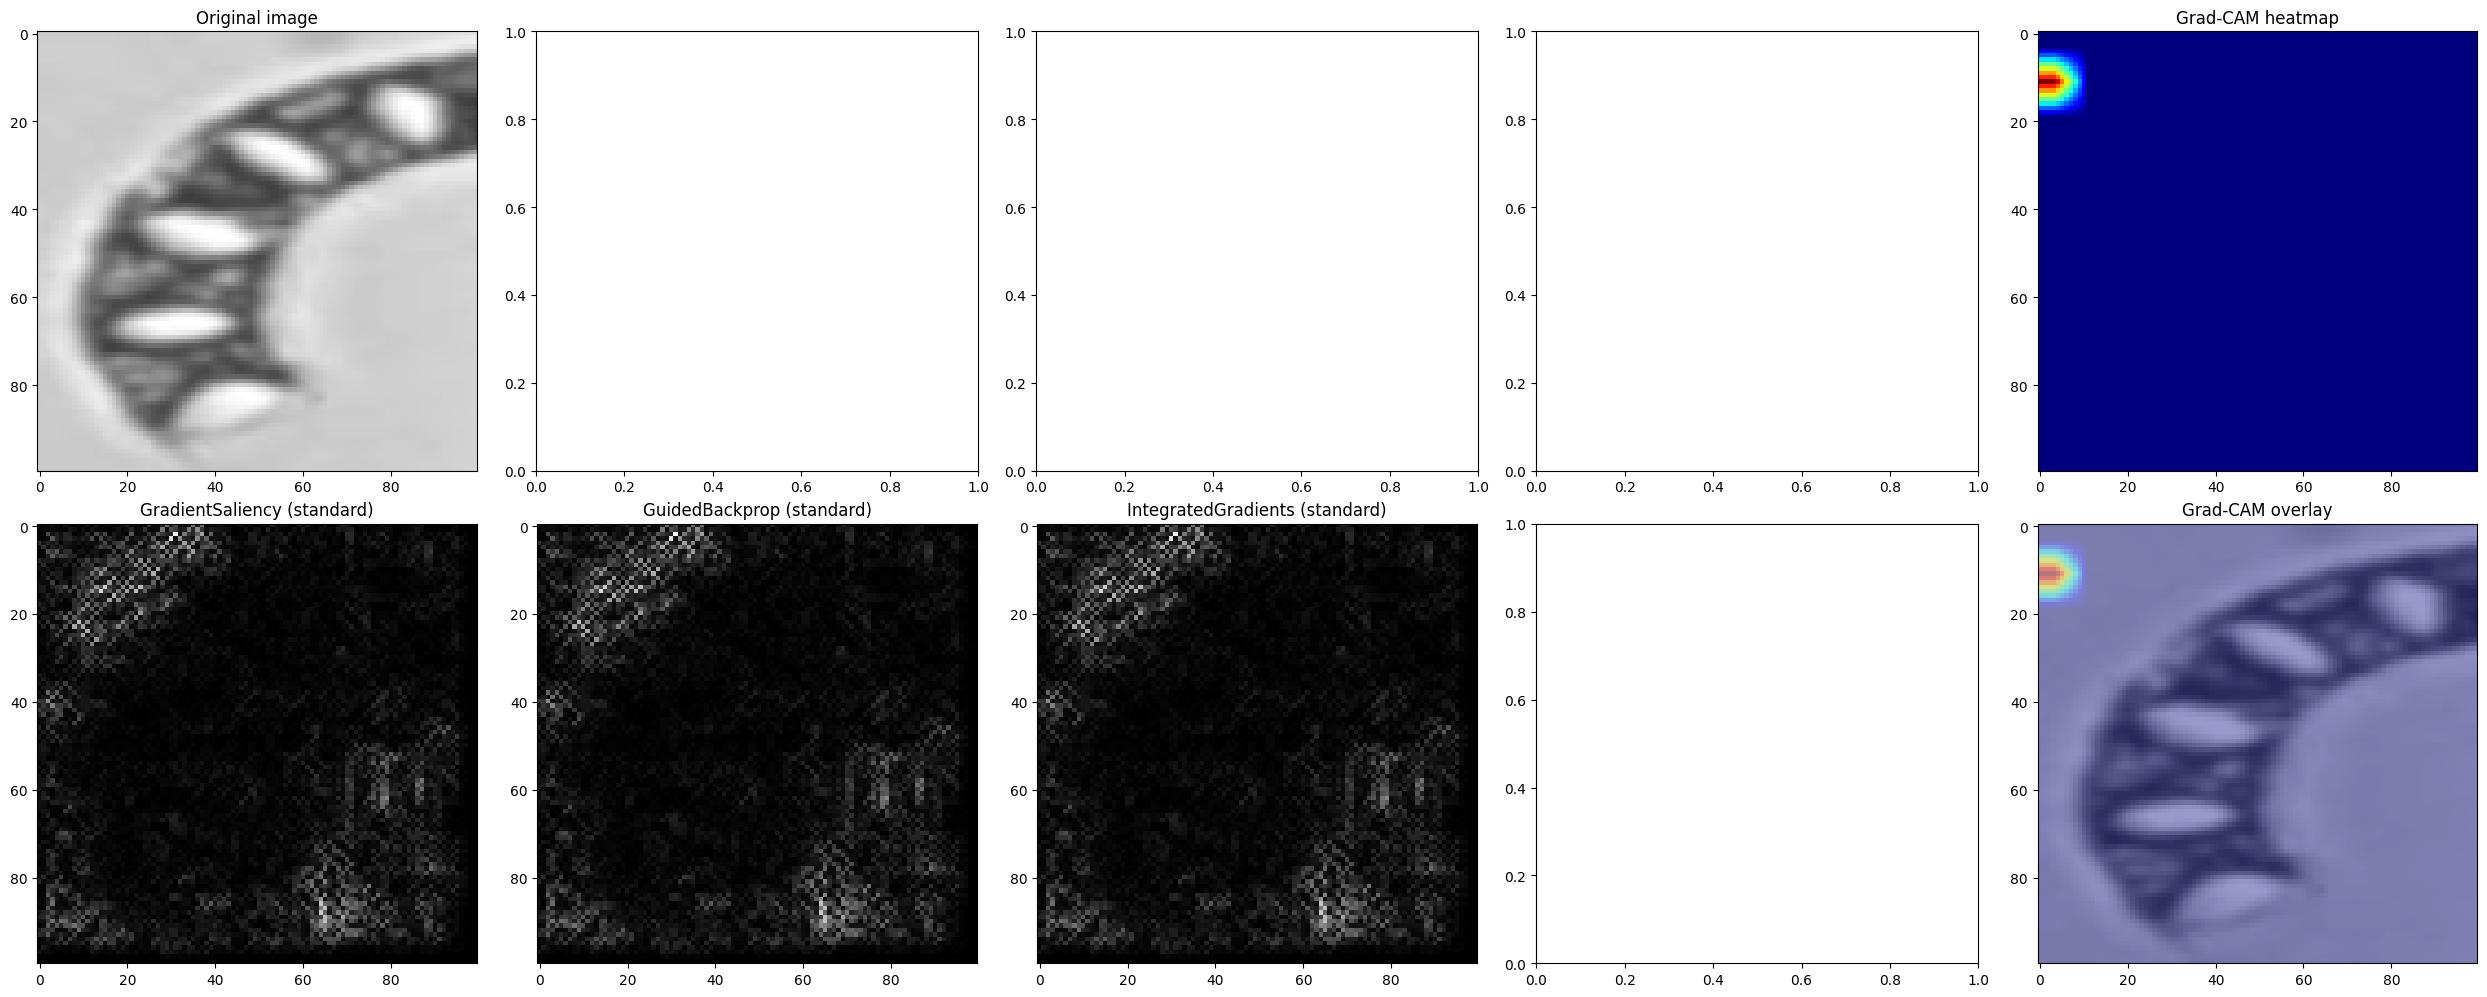

Processed: \\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist\Eucampia\ecotaxa_Eucampia_88520704-7862-427A-BF47-E6B66974DA0C.jpg


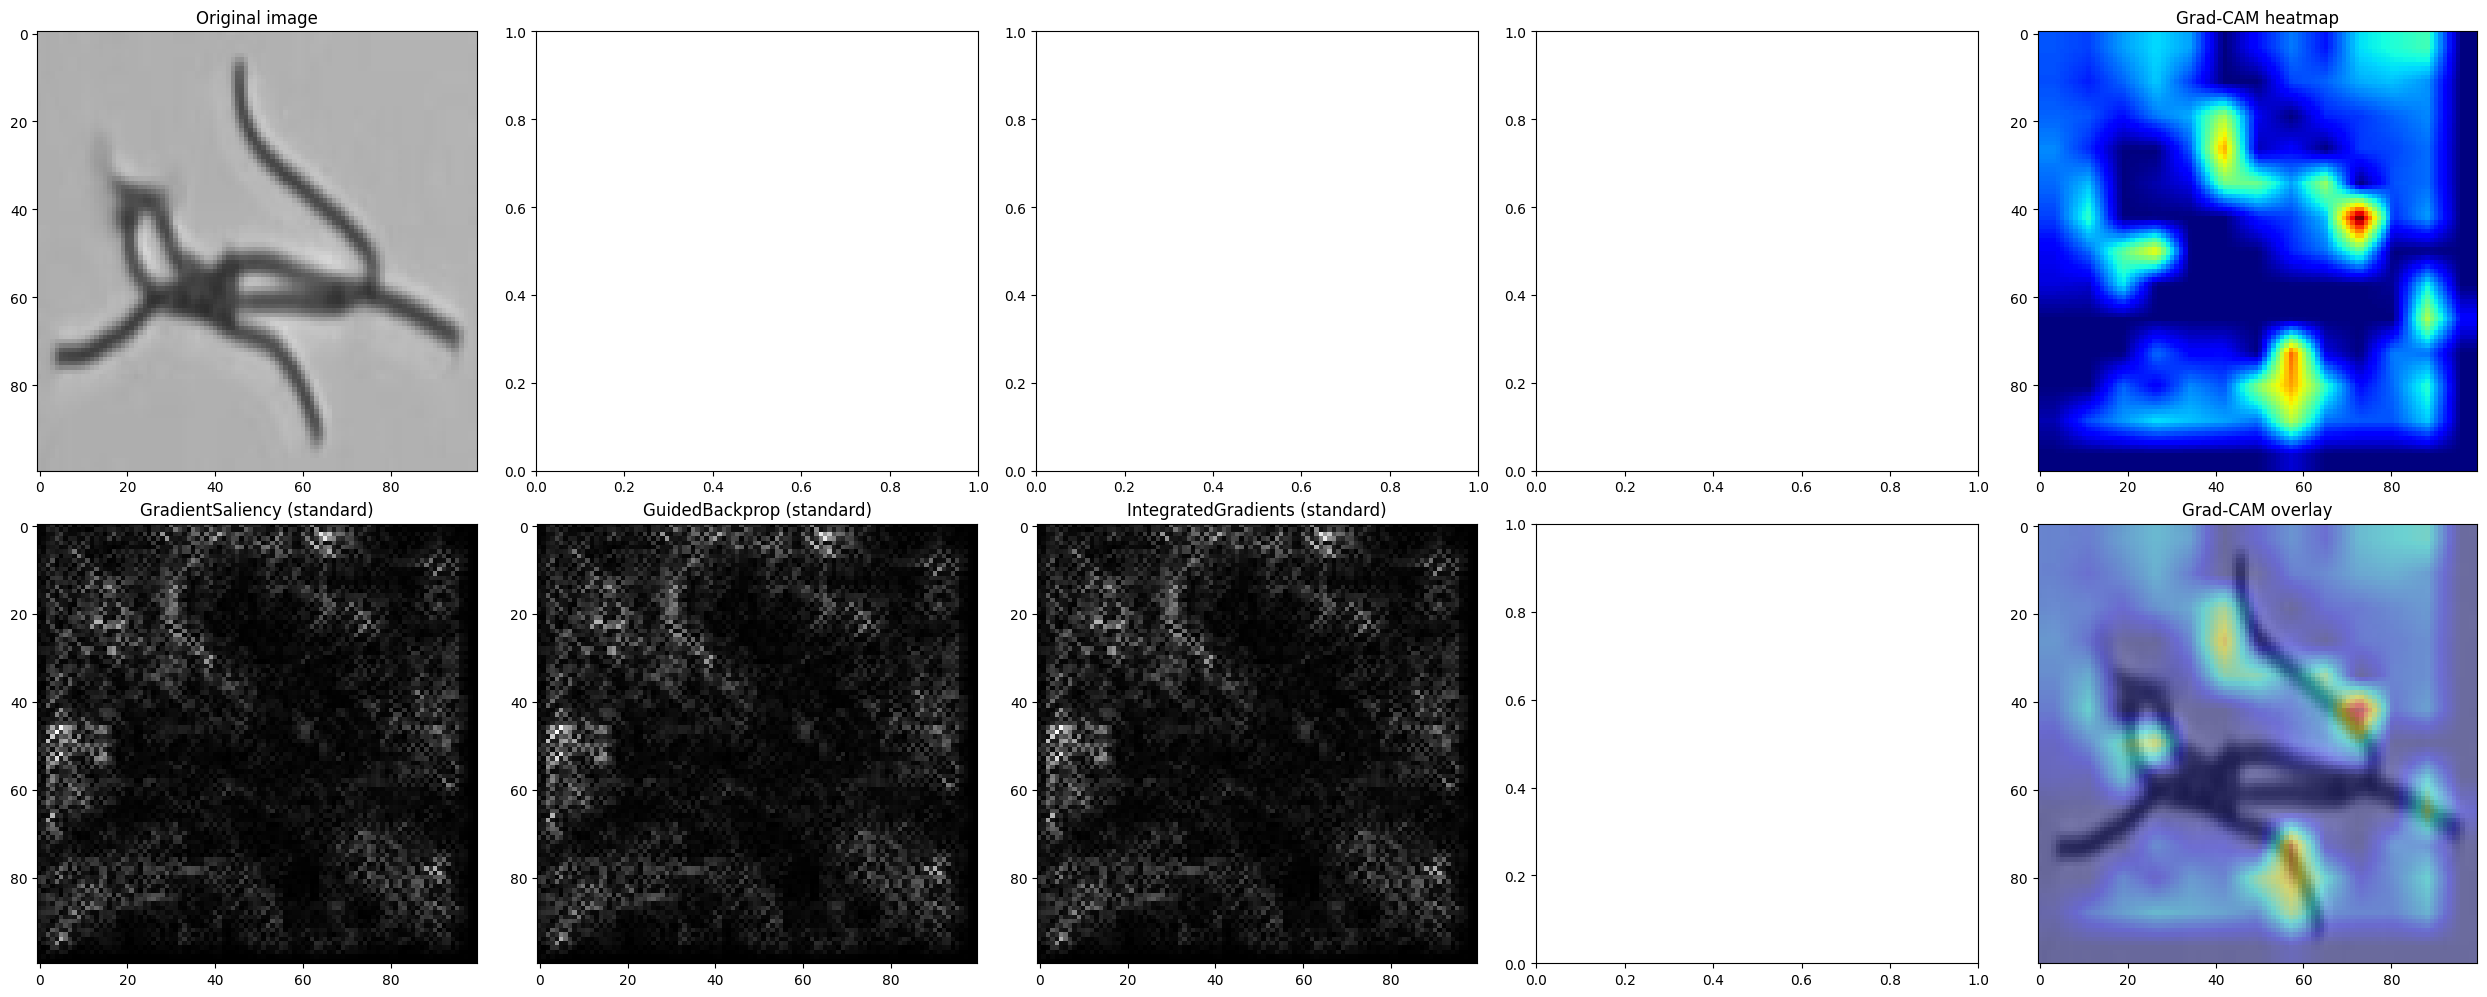

Processed: \\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist\Cnidaria\ecotaxa_Cnidaria_5ADD8B7F-618C-480A-A91D-94F7F1410C42.jpg


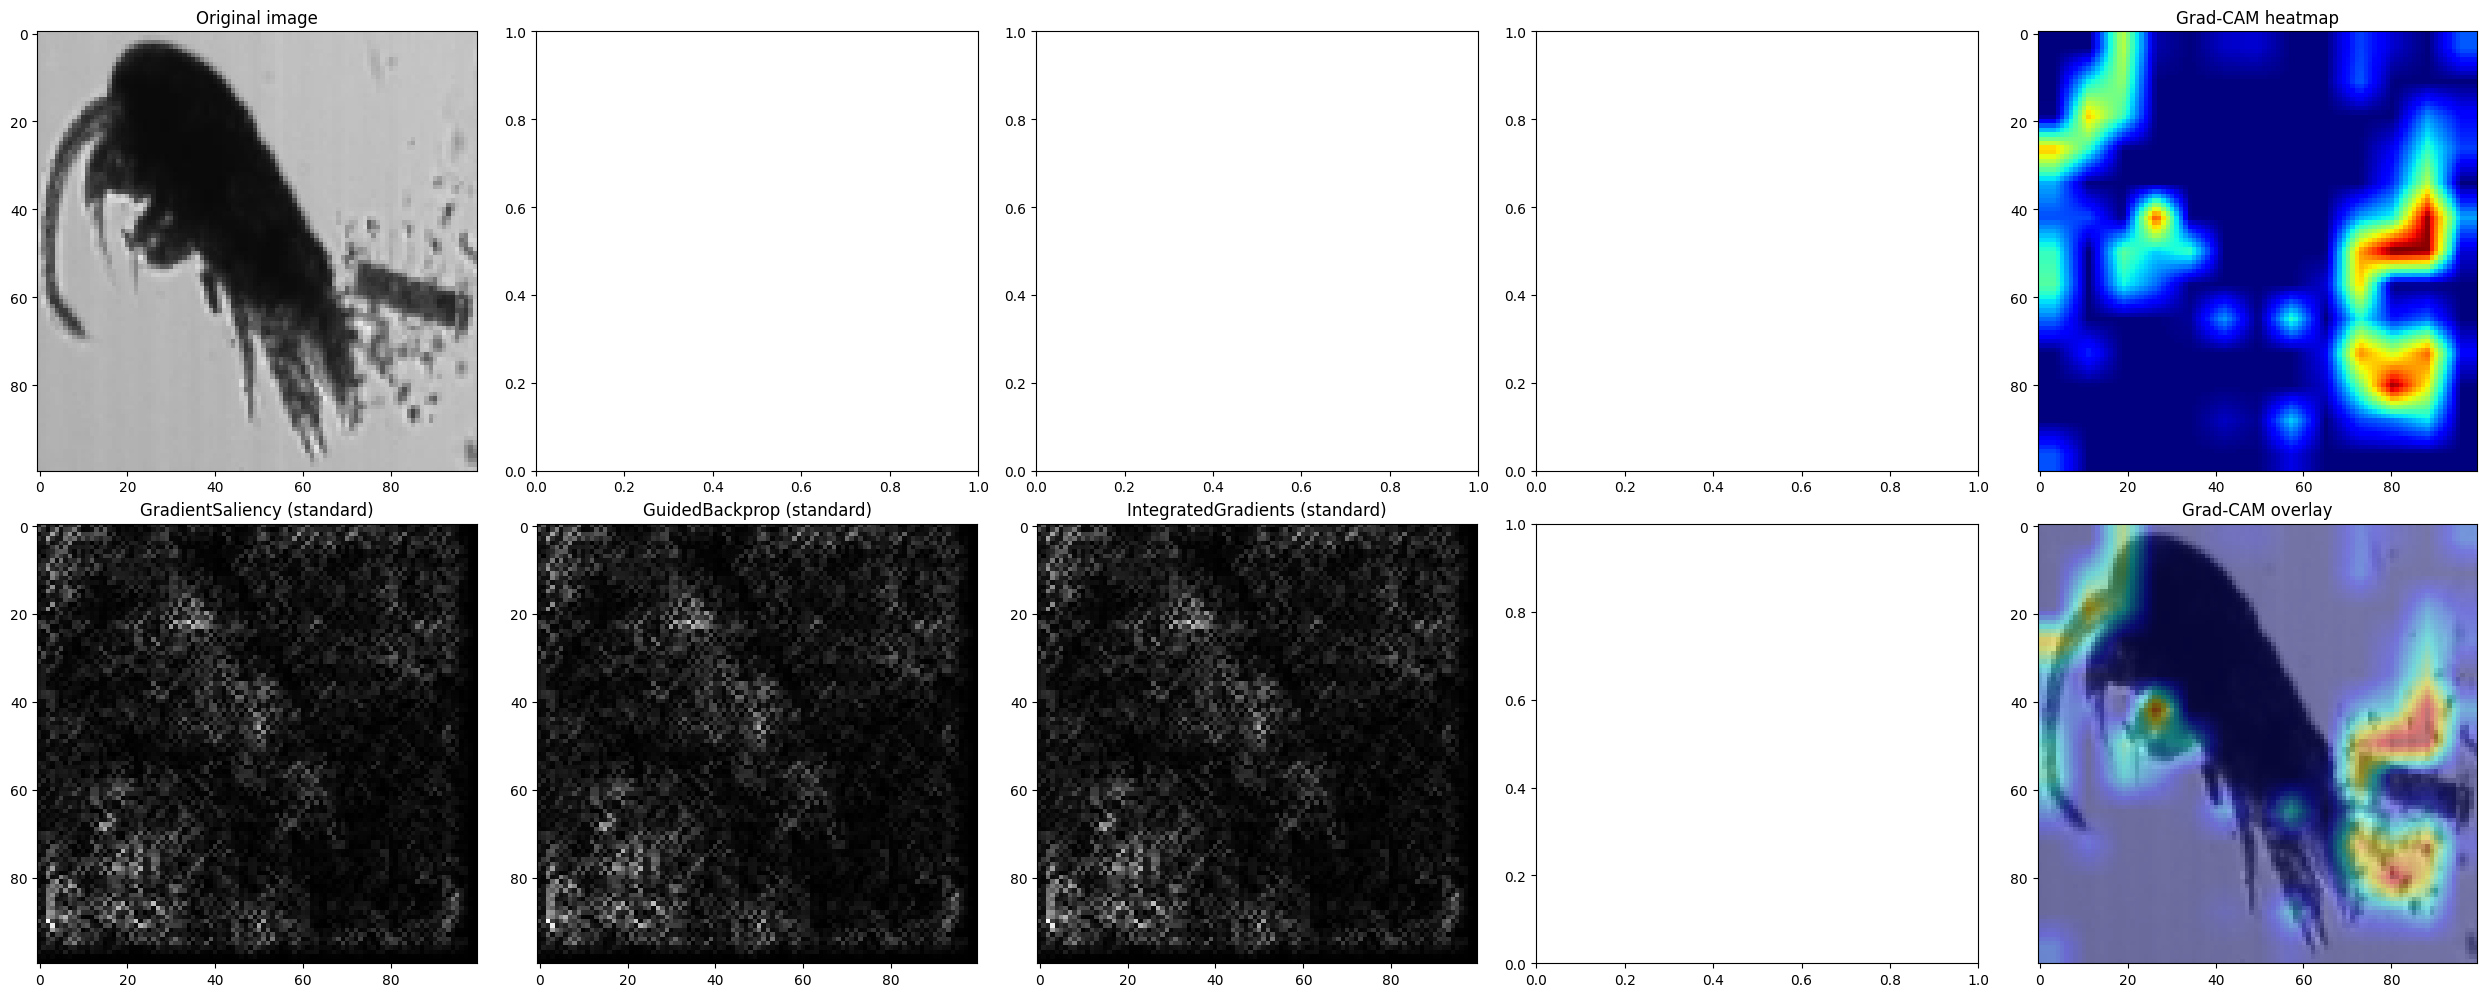

Processed: \\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist\Crustacea\ecotaxa_Crustacea_CDFFF257-D4D8-4845-AE43-97DDFE4FD42A.jpg


In [4]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

from planktonclas import paths, utils, data_utils
from planktonclas.data_utils import k_crop_data_sequence
from planktonclas.visualization.saliency import GradientSaliency
from planktonclas.visualization.guided_backprop import GuidedBackprop
from planktonclas.visualization.integrated_gradients import IntegratedGradients

# ---- USER INPUTS ----
DATA_DIR = r"\\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC5\data\training\images_exist"
MODEL_NAME = 'final_model.h5'
TIMESTAMP = 'Phytoplankton_EfficientNetV2B0'
NUM_SAMPLES = 5  # Number of random images to sample
GRADCAM_LAYER = "block3a_expand_conv"  # Layer for Grad-CAM

# ---- PRIORITY CLASSES BASED ON DISCUSSION ----
PRIORITY_CLASSES = [
    "Artefact", "Asterionella", "Eucampia",  # dominant, high performance
    "Cnidaria", "Crustacea", "Foraminifera",  # challenging, low representation
    "Coscinodiscus_concinnus", "Pollen", "Melosira"  # borderline cases
]

# ---- LOAD CONFIG ----
paths.timestamp = TIMESTAMP
import json
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)

# ---- LOAD MODEL ----
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), 
                   custom_objects=utils.get_custom_objects())

# ---- HELPER FUNCTIONS ----
def load_random_images(data_dir, classes, num_samples=5):
    selected_files = []
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if os.path.exists(cls_path):
            files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if files:
                selected_files.append(random.choice(files))
    return selected_files[:num_samples]

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ---- PROCESS IMAGES ----
sample_files = load_random_images(DATA_DIR, PRIORITY_CLASSES, NUM_SAMPLES)

for img_path in sample_files:
    # Preprocess image
    data_gen = k_crop_data_sequence(inputs=[img_path],
                                    im_size=conf['model']['image_size'],
                                    mean_RGB=conf['dataset']['mean_RGB'],
                                    std_RGB=conf['dataset']['std_RGB'],
                                    preprocess_mode=conf['model']['preprocess_mode'],
                                    aug_params=None,
                                    crop_mode='random',
                                    crop_number=1,
                                    filemode='local')
    img_arr = data_gen.__getitem__(0).squeeze(axis=0)
    
    # Load original image for overlay
    image = data_utils.load_image(img_path, filemode='local')
    image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
    
    # ---- COMPUTE SALIENCY METHODS ----
    saliency_methods = [GradientSaliency, GuidedBackprop, IntegratedGradients]
    masks = []
    for method in saliency_methods:
        saliency_func = method(model)
        mask = saliency_func.get_mask(img_arr)
        mask = np.sum(np.abs(mask), axis=2)
        masks.append(mask)
    
    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_arr, model, GRADCAM_LAYER)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.6, heatmap_color, 0.4, 0)
    
    # ---- PLOT RESULTS ----
    fig, axs = plt.subplots(2, len(saliency_methods)+2, figsize=(5*(len(saliency_methods)+2), 10))
    axs = axs.T.flatten()
    
    axs[0].imshow(image)
    axs[0].set_title("Original image", fontsize=12)
    
    for i, mask in enumerate(masks):
        axs[i*2+1].imshow(mask, cmap='gray')
        axs[i*2+1].set_title(f"{saliency_methods[i].__name__} (standard)", fontsize=12)
    
    axs[-2].imshow(heatmap_resized, cmap='jet')
    axs[-2].set_title("Grad-CAM heatmap", fontsize=12)
    
    axs[-1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[-1].set_title("Grad-CAM overlay", fontsize=12)
    
    plt.tight_layout()
    plt.show()
    print(f"Processed: {img_path}")
